In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Wczytanie i wstępna analiza danych

In [77]:
df = pd.read_csv("jakos_wody_2.csv", index_col=0)
print(df.head(10))

          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135   

In [78]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 281.5 KB
None


In [79]:
print(df.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.252442  
std       80.824064        3.308162        16.175008     0.780382     0.434480  


Wizualizacja rozkładu zmiennej docelowej (Potability) i sprawdzenie braku danych 

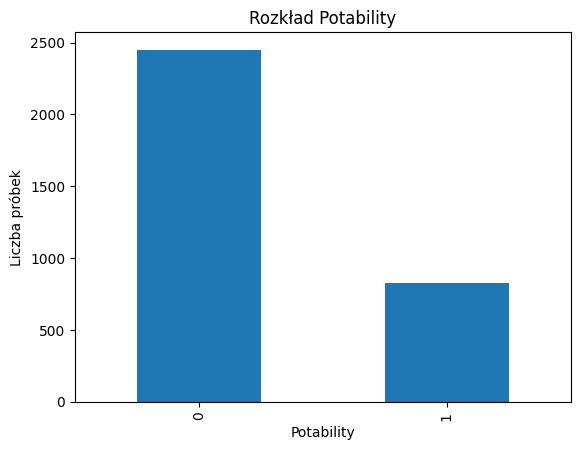

Ilość próbek: 
 Potability
0    2449
1     827
Name: count, dtype: int64
Braki danych:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


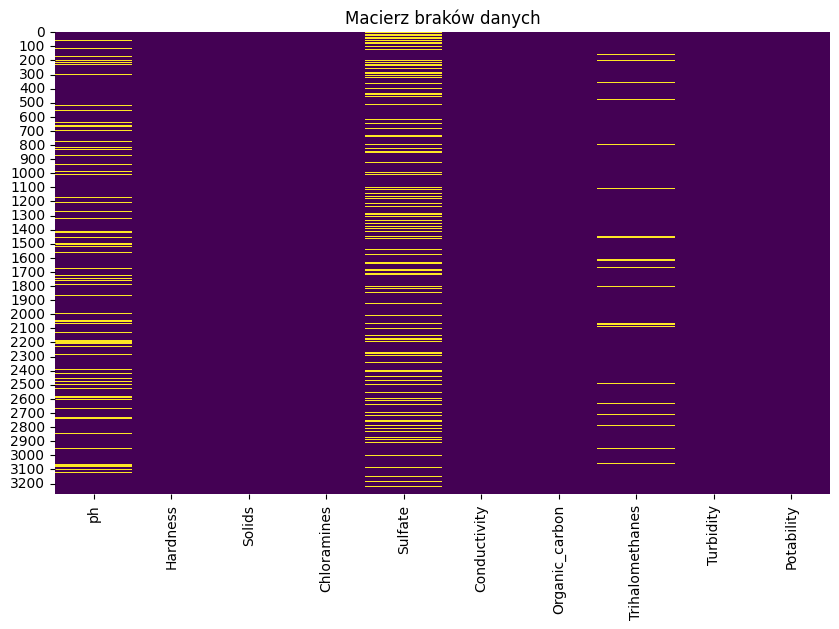

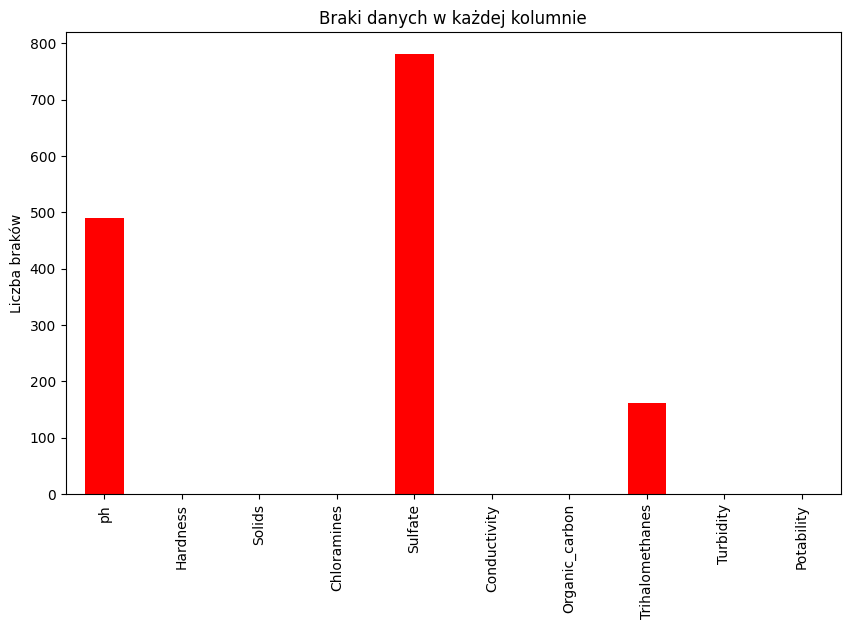

In [80]:
df['Potability'].value_counts().plot(kind='bar')
plt.title('Rozkład Potability')
plt.xlabel('Potability')
plt.ylabel('Liczba próbek')
plt.show()
print("Ilość próbek: \n", df['Potability'].value_counts())

missing_values = df.isnull().sum()
print("Braki danych:\n", missing_values)

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Macierz braków danych')
plt.show()

missing_values.plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Braki danych w każdej kolumnie')
plt.ylabel('Liczba braków')
plt.show()

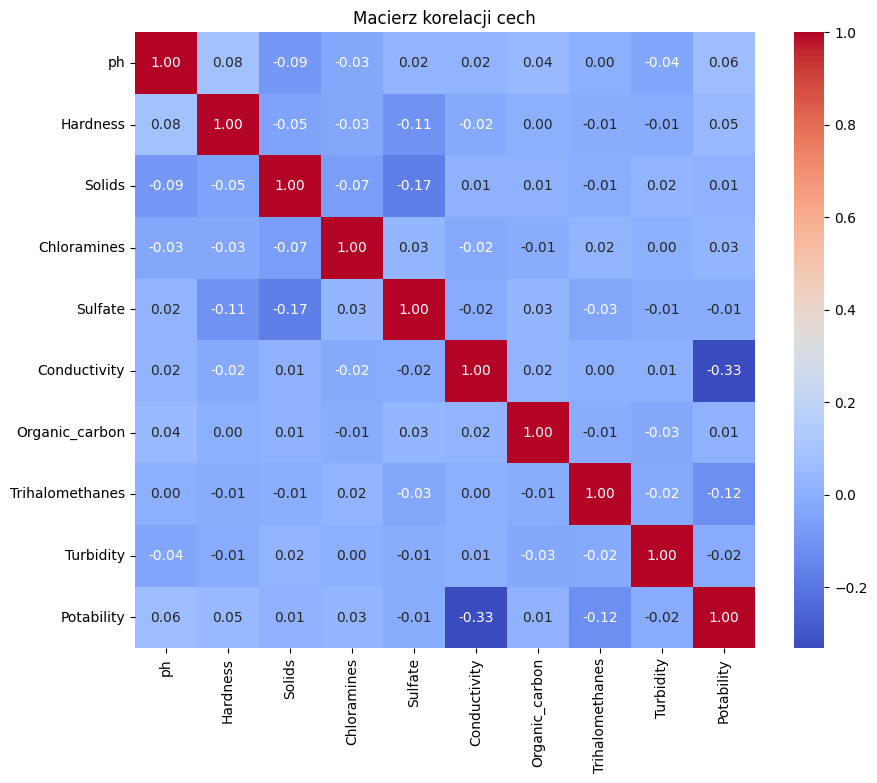

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji cech")
plt.show()

Wizualizacja rozkładów cech dla klas Potability

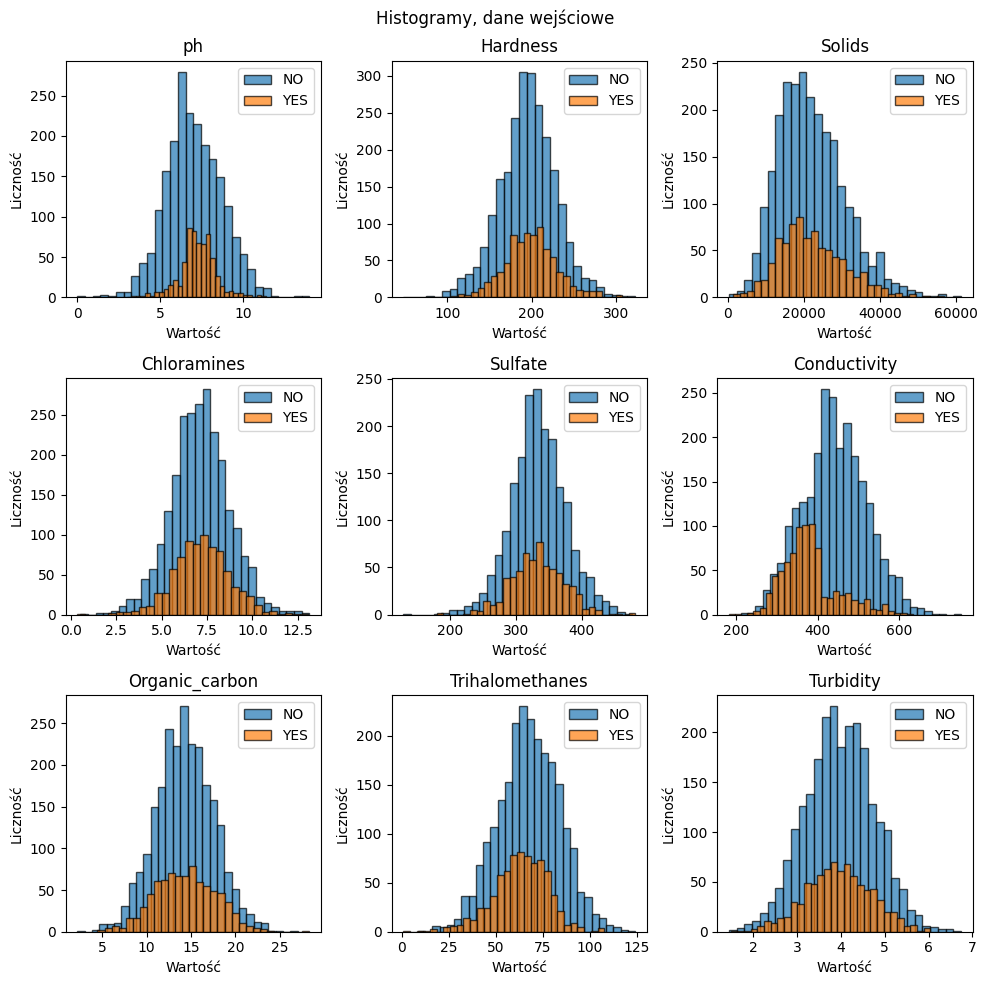

In [82]:

fig, axes = plt.subplots(3, 3, figsize=(10, 10))  
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):  
    ax = axes[i] 
    cl0 = df.loc[df["Potability"] == 0, col]
    cl1 = df.loc[df["Potability"] == 1, col]

    ax.hist(cl0, bins=30, alpha=0.7, label="NO", edgecolor='black')
    ax.hist(cl1, bins=30, alpha=0.7, label="YES", edgecolor='black')

    ax.legend()
    ax.set_title(col)
    ax.set_xlabel("Wartość")
    ax.set_ylabel("Liczność")

plt.suptitle("Histogramy, dane wejściowe")
plt.tight_layout()
plt.show()



Imputacja braków danych i testowanie modeli klasyfikacyjnych


Wyniki dla metody : Drop 
KNN: Accuracy: 0.7996688741721855, Precision: 0.5862068965517241, Recall: 0.375, F1-score: 0.45739910313901344
SVM: Accuracy: 0.6539735099337748, Precision: 0.36531365313653136, Recall: 0.7279411764705882, F1-score: 0.4864864864864865
Decision Tree: Accuracy: 0.8410596026490066, Precision: 0.6923076923076923, Recall: 0.5294117647058824, F1-score: 0.6


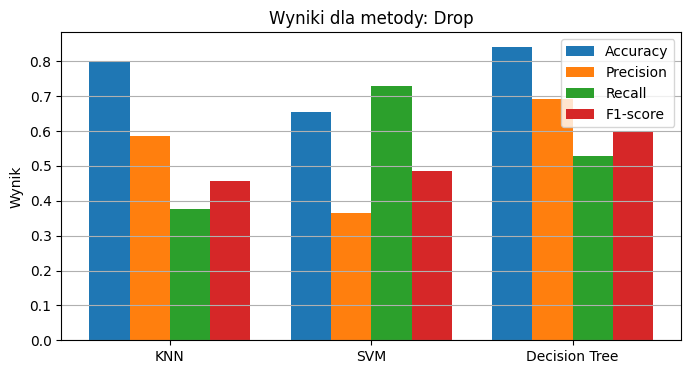


Wyniki dla metody : Mean 
KNN: Accuracy: 0.8229908443540183, Precision: 0.6417910447761194, Recall: 0.5584415584415584, F1-score: 0.5972222222222222
SVM: Accuracy: 0.7019328585961343, Precision: 0.4251207729468599, Recall: 0.7619047619047619, F1-score: 0.5457364341085271
Decision Tree: Accuracy: 0.8657171922685656, Precision: 0.7734806629834254, Recall: 0.6060606060606061, F1-score: 0.6796116504854369


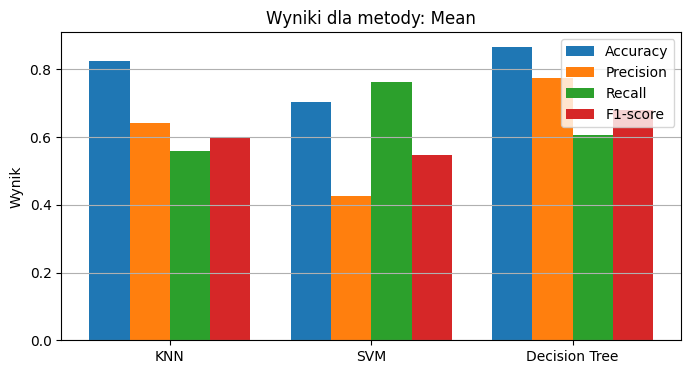


Wyniki dla metody : Median 
KNN: Accuracy: 0.8229908443540183, Precision: 0.6417910447761194, Recall: 0.5584415584415584, F1-score: 0.5972222222222222
SVM: Accuracy: 0.7049847405900305, Precision: 0.4282238442822384, Recall: 0.7619047619047619, F1-score: 0.5482866043613707
Decision Tree: Accuracy: 0.8657171922685656, Precision: 0.7734806629834254, Recall: 0.6060606060606061, F1-score: 0.6796116504854369


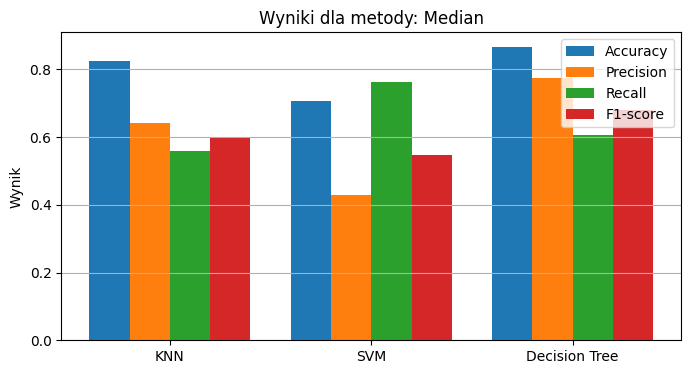


Wyniki dla metody : Mode 
KNN: Accuracy: 0.7965412004069176, Precision: 0.5846994535519126, Recall: 0.46320346320346323, F1-score: 0.5169082125603864
SVM: Accuracy: 0.6866734486266531, Precision: 0.4114942528735632, Recall: 0.7748917748917749, F1-score: 0.5375375375375375
Decision Tree: Accuracy: 0.8850457782299085, Precision: 0.8138297872340425, Recall: 0.6623376623376623, F1-score: 0.7303102625298329


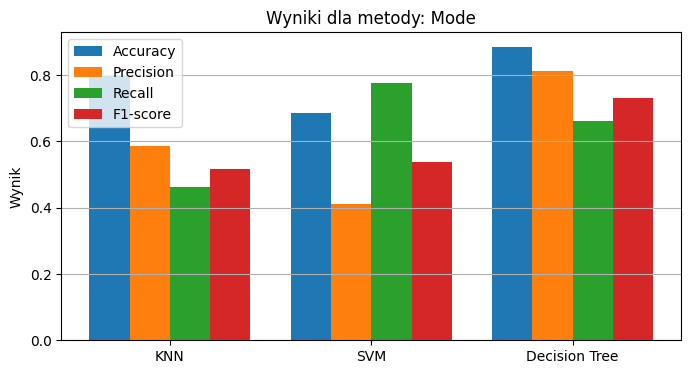


Wyniki dla metody : KNN dla k = 5 
KNN: Accuracy: 0.8168870803662258, Precision: 0.6378378378378379, Recall: 0.5108225108225108, F1-score: 0.5673076923076923
SVM: Accuracy: 0.7090539165818922, Precision: 0.43243243243243246, Recall: 0.7619047619047619, F1-score: 0.5517241379310345
Decision Tree: Accuracy: 0.854526958290946, Precision: 0.7417582417582418, Recall: 0.5844155844155844, F1-score: 0.6537530266343826


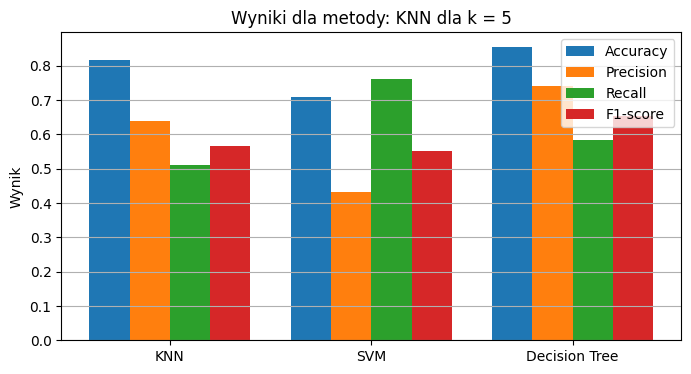


Wyniki dla metody : KNN dla k = 10 
KNN: Accuracy: 0.8250254323499492, Precision: 0.6577540106951871, Recall: 0.5324675324675324, F1-score: 0.5885167464114832
SVM: Accuracy: 0.7049847405900305, Precision: 0.42857142857142855, Recall: 0.7662337662337663, F1-score: 0.5496894409937888
Decision Tree: Accuracy: 0.8708036622583927, Precision: 0.7921348314606742, Recall: 0.6103896103896104, F1-score: 0.6894865525672371


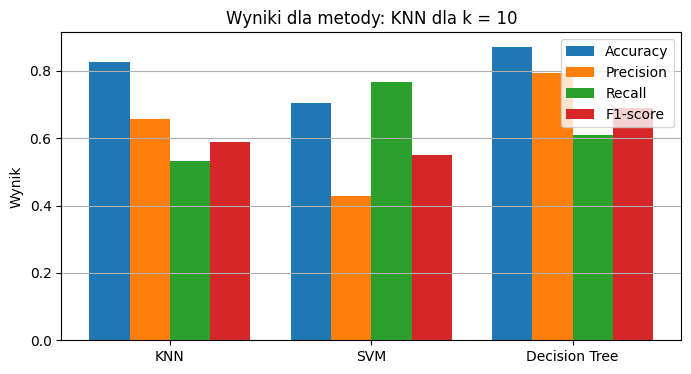


Wyniki dla metody : KNN dla k = 20 
KNN: Accuracy: 0.8199389623601221, Precision: 0.6421052631578947, Recall: 0.5281385281385281, F1-score: 0.5795724465558195
SVM: Accuracy: 0.7090539165818922, Precision: 0.43309002433090027, Recall: 0.7705627705627706, F1-score: 0.5545171339563862
Decision Tree: Accuracy: 0.8646998982706002, Precision: 0.7722222222222223, Recall: 0.6017316017316018, F1-score: 0.6763990267639902


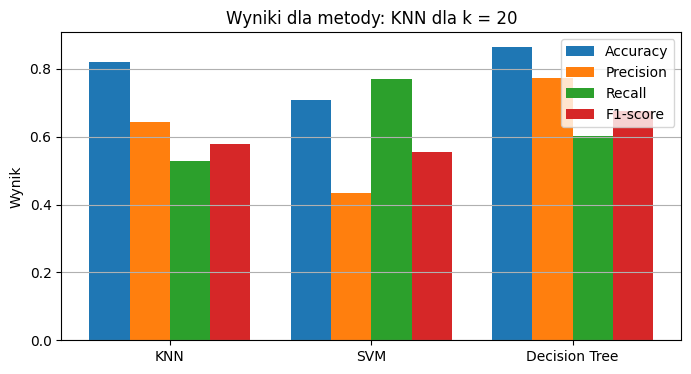


Wyniki dla metody : Iterative (10 iteracji) 
KNN: Accuracy: 0.8240081383519837, Precision: 0.6479591836734694, Recall: 0.5497835497835498, F1-score: 0.594847775175644
SVM: Accuracy: 0.7080366225839267, Precision: 0.4320388349514563, Recall: 0.7705627705627706, F1-score: 0.5536547433903577
Decision Tree: Accuracy: 0.8575788402848423, Precision: 0.7407407407407407, Recall: 0.6060606060606061, F1-score: 0.6666666666666666


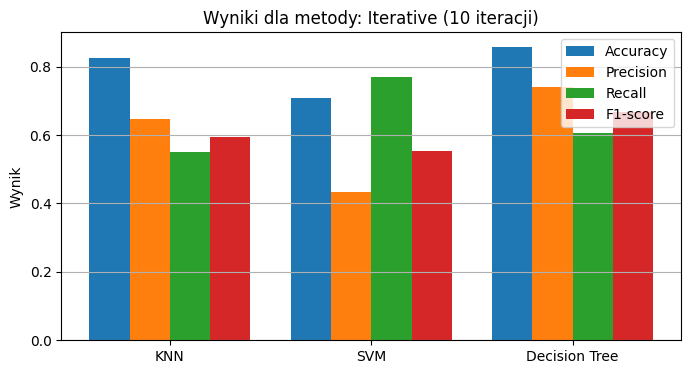


Wyniki dla metody : Iterative (20 iteracji) 
KNN: Accuracy: 0.8240081383519837, Precision: 0.6479591836734694, Recall: 0.5497835497835498, F1-score: 0.594847775175644
SVM: Accuracy: 0.7080366225839267, Precision: 0.4320388349514563, Recall: 0.7705627705627706, F1-score: 0.5536547433903577
Decision Tree: Accuracy: 0.8596134282807731, Precision: 0.7486631016042781, Recall: 0.6060606060606061, F1-score: 0.6698564593301436


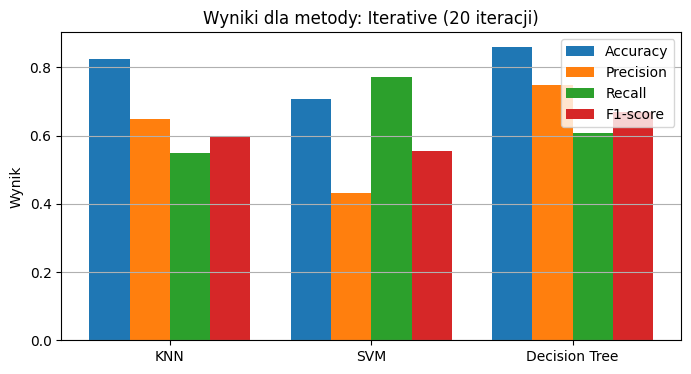


Wyniki dla metody : Iterative (DecisionTree) 
KNN: Accuracy: 0.8280773143438453, Precision: 0.6565656565656566, Recall: 0.5627705627705628, F1-score: 0.6060606060606061
SVM: Accuracy: 0.7060020345879959, Precision: 0.42995169082125606, Recall: 0.7705627705627706, F1-score: 0.5519379844961241
Decision Tree: Accuracy: 0.8657171922685656, Precision: 0.7796610169491526, Recall: 0.5974025974025974, F1-score: 0.6764705882352942


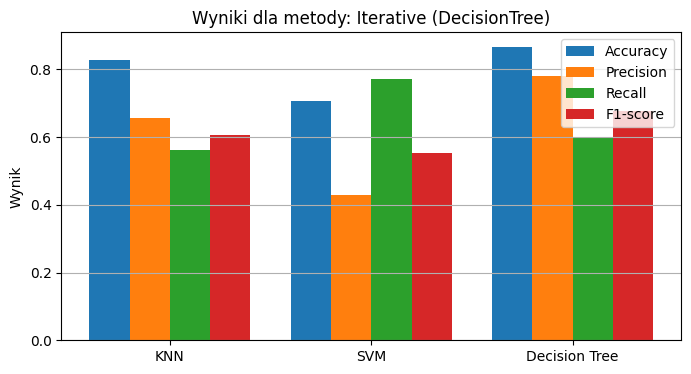


Wyniki dla metody : Iterative (RandomForest) 
KNN: Accuracy: 0.8199389623601221, Precision: 0.6363636363636364, Recall: 0.5454545454545454, F1-score: 0.5874125874125874
SVM: Accuracy: 0.7029501525940997, Precision: 0.42650602409638555, Recall: 0.7662337662337663, F1-score: 0.5479876160990712
Decision Tree: Accuracy: 0.854526958290946, Precision: 0.7315789473684211, Recall: 0.6017316017316018, F1-score: 0.6603325415676959


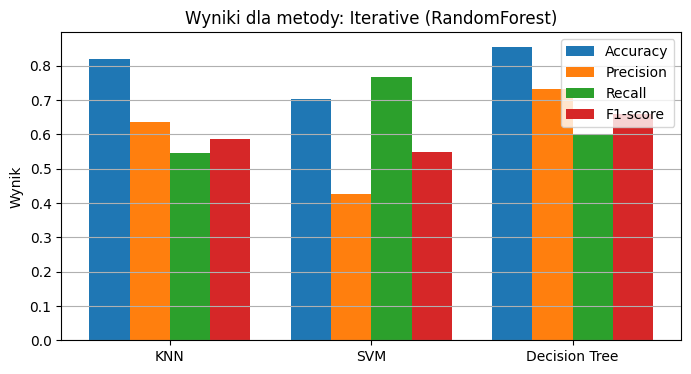

In [84]:
df_drop = df.dropna() 
df_mean = df.copy()
df_median = df.copy()
df_mode = df.copy()
df_knn_5 = df.copy()
df_knn_10 = df.copy()
df_knn_20 = df.copy()
df_iter_10 = df.copy()
df_iter_20 = df.copy()
df_iter_dt = df.copy()
df_iter_rf = df.copy()

imputer_mean = SimpleImputer(strategy="mean")
df_mean.iloc[:, :-1] = imputer_mean.fit_transform(df_mean.iloc[:, :-1])

imputer_median = SimpleImputer(strategy="median")
df_median.iloc[:, :-1] = imputer_median.fit_transform(df_median.iloc[:, :-1])

imputer_mode = SimpleImputer(strategy="most_frequent")
df_mode.iloc[:, :-1] = imputer_mode.fit_transform(df_mode.iloc[:, :-1])

imputer_knn_5 = KNNImputer(n_neighbors=5)
df_knn_5.iloc[:, :-1] = imputer_knn_5.fit_transform(df_knn_5.iloc[:, :-1])

imputer_knn_10 = KNNImputer(n_neighbors=10)
df_knn_10.iloc[:, :-1] = imputer_knn_10.fit_transform(df_knn_10.iloc[:, :-1])

imputer_knn_20 = KNNImputer(n_neighbors=20)
df_knn_20.iloc[:, :-1] = imputer_knn_20.fit_transform(df_knn_20.iloc[:, :-1])

imputer_iter_10 = IterativeImputer(max_iter=10, random_state=42)
df_iter_10.iloc[:, :-1] = imputer_iter_10.fit_transform(df_iter_10.iloc[:, :-1])

imputer_iter_20 = IterativeImputer(max_iter=20, random_state=42)
df_iter_20.iloc[:, :-1] = imputer_iter_20.fit_transform(df_iter_20.iloc[:, :-1])

imputer_iter_dt = IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), random_state=42)
df_iter_dt.iloc[:, :-1] = imputer_iter_dt.fit_transform(df_iter_dt.iloc[:, :-1])

imputer_iter_rf = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
df_iter_rf.iloc[:, :-1] = imputer_iter_rf.fit_transform(df_iter_rf.iloc[:, :-1])

scaler = MinMaxScaler()
df_drop.iloc[:, :-1] = scaler.fit_transform(df_drop.iloc[:, :-1])
df_mean.iloc[:, :-1] = scaler.transform(df_mean.iloc[:, :-1])
df_median.iloc[:, :-1] = scaler.transform(df_median.iloc[:, :-1])
df_mode.iloc[:, :-1] = scaler.transform(df_mode.iloc[:, :-1])
df_knn_5.iloc[:, :-1] = scaler.transform(df_knn_5.iloc[:, :-1])
df_knn_10.iloc[:, :-1] = scaler.transform(df_knn_10.iloc[:, :-1])
df_knn_20.iloc[:, :-1] = scaler.transform(df_knn_20.iloc[:, :-1])
df_iter_10.iloc[:, :-1] = scaler.fit_transform(df_iter_10.iloc[:, :-1])
df_iter_20.iloc[:, :-1] = scaler.transform(df_iter_20.iloc[:, :-1])
df_iter_dt.iloc[:, :-1] = scaler.transform(df_iter_dt.iloc[:, :-1])
df_iter_rf.iloc[:, :-1] = scaler.transform(df_iter_rf.iloc[:, :-1])

def split_data(df):
    X = df.iloc[:, :-1].values  
    y = df.iloc[:, -1].values   
    return train_test_split(X, y, test_size=0.3, random_state=0)

X_train_drop, X_test_drop, y_train_drop, y_test_drop = split_data(df_drop)
X_train_mean, X_test_mean, y_train_mean, y_test_mean = split_data(df_mean)
X_train_median, X_test_median, y_train_median, y_test_median = split_data(df_median)
X_train_mode, X_test_mode, y_train_mode, y_test_mode = split_data(df_mode)
X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5 = split_data(df_knn_5)
X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10 = split_data(df_knn_10)
X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20 = split_data(df_knn_20)
X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10 = split_data(df_iter_10)
X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20 = split_data(df_iter_20)
X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt = split_data(df_iter_dt)
X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf = split_data(df_iter_rf)

knn = KNeighborsClassifier(n_neighbors=7, weights="distance", metric="manhattan")
svm = SVC(kernel="rbf", C=10, gamma=0.1, class_weight='balanced')
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, criterion='entropy')

def train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1_metric

for name, X_train, X_test, y_train, y_test in [
    ("Drop", X_train_drop, X_test_drop, y_train_drop, y_test_drop),
    ("Mean", X_train_mean, X_test_mean, y_train_mean, y_test_mean),
    ("Median", X_train_median, X_test_median, y_train_median, y_test_median),
    ("Mode", X_train_mode, X_test_mode, y_train_mode, y_test_mode),
    ("KNN dla k = 5", X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5),
    ("KNN dla k = 10", X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10),
    ("KNN dla k = 20", X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20),
    ("Iterative (10 iteracji)", X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10),
    ("Iterative (20 iteracji)", X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20),
    ("Iterative (DecisionTree)", X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt),
    ("Iterative (RandomForest)", X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf)
]:
    print(f"\nWyniki dla metody : {name} ")

    acc_knn, prec_knn, recall_knn, f1_knn = train(knn, X_train, X_test, y_train, y_test)
    print(f"KNN: Accuracy: {acc_knn}, Precision: {prec_knn}, Recall: {recall_knn}, F1-score: {f1_knn}")

    acc_svm, prec_svm, recall_svm, f1_svm = train(svm, X_train, X_test, y_train, y_test)
    print(f"SVM: Accuracy: {acc_svm}, Precision: {prec_svm}, Recall: {recall_svm}, F1-score: {f1_svm}")

    acc_dt, prec_dt, recall_dt, f1_dt = train(dt, X_train, X_test, y_train, y_test)
    print(f"Decision Tree: Accuracy: {acc_dt}, Precision: {prec_dt}, Recall: {recall_dt}, F1-score: {f1_dt}")

    labels = ["KNN", "SVM", "Decision Tree"]
    accuracy = [acc_knn, acc_svm, acc_dt]
    precision = [prec_knn, prec_svm, prec_dt]
    recall = [recall_knn, recall_svm, recall_dt]
    f1_scores = [f1_knn, f1_svm, f1_dt]

    metrics = [accuracy, precision, recall, f1_scores]
    metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]

    plt.figure(figsize=(8, 4))

    for i, metric in enumerate(metrics):
        plt.bar([x + i * 0.2 for x in range(len(labels))], metric, width=0.2, label=metric_names[i])

    plt.xticks([x + 0.3 for x in range(len(labels))], labels)
    plt.ylabel("Wynik")
    plt.title(f"Wyniki dla metody: {name}")
    plt.legend()
    plt.grid(axis="y")
    plt.show()



Wyniki dla metody: Drop - Imputacja: df
KNN: Accuracy: 0.7450331125827815, Precision: 0.3125, Recall: 0.11029411764705882, F1-score: 0.16304347826086957
SVM: Accuracy: 0.7748344370860927, Precision: 0.0, Recall: 0.0, F1-score: 0.0
Decision Tree: Accuracy: 0.8443708609271523, Precision: 0.7019230769230769, Recall: 0.5367647058823529, F1-score: 0.6083333333333333


/Users/kacperwilkolazki/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


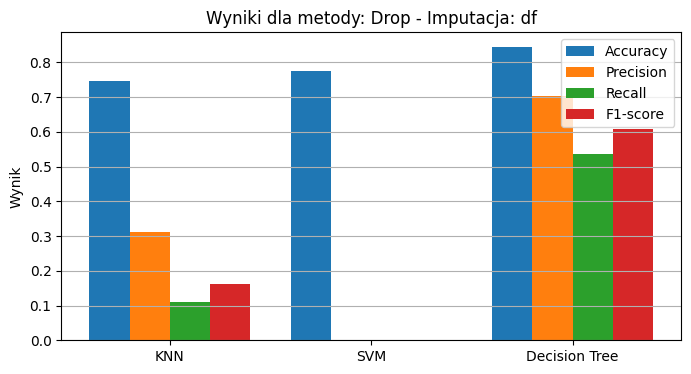


Wyniki dla metody: Drop ph - Imputacja: drop_ph_mean
KNN: Accuracy: 0.7914547304170906, Precision: 0.5773809523809523, Recall: 0.4199134199134199, F1-score: 0.48621553884711777
SVM: Accuracy: 0.698880976602238, Precision: 0.4235294117647059, Recall: 0.7792207792207793, F1-score: 0.5487804878048781
Decision Tree: Accuracy: 0.7711088504577823, Precision: 0.51171875, Recall: 0.5670995670995671, F1-score: 0.5379876796714579


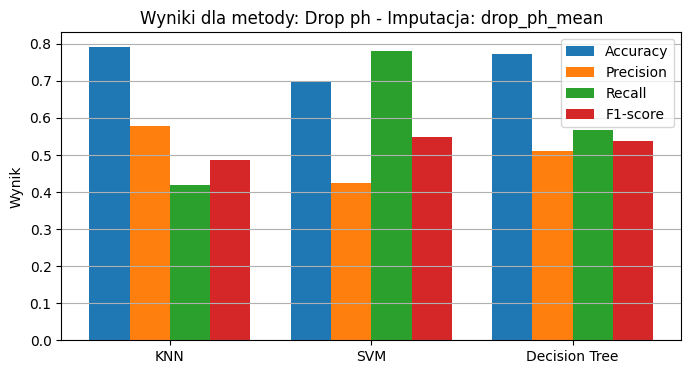


Wyniki dla metody: Drop ph - Imputacja: drop_ph_median
KNN: Accuracy: 0.7914547304170906, Precision: 0.5773809523809523, Recall: 0.4199134199134199, F1-score: 0.48621553884711777
SVM: Accuracy: 0.6978636826042727, Precision: 0.4225352112676056, Recall: 0.7792207792207793, F1-score: 0.547945205479452
Decision Tree: Accuracy: 0.7711088504577823, Precision: 0.51171875, Recall: 0.5670995670995671, F1-score: 0.5379876796714579


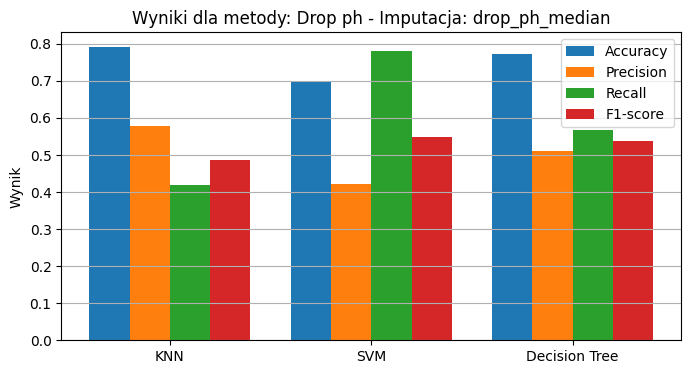


Wyniki dla metody: Drop ph - Imputacja: drop_ph_mode
KNN: Accuracy: 0.775178026449644, Precision: 0.5324675324675324, Recall: 0.354978354978355, F1-score: 0.42597402597402595
SVM: Accuracy: 0.6998982706002035, Precision: 0.423444976076555, Recall: 0.7662337662337663, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.7782299084435402, Precision: 0.525691699604743, Recall: 0.5757575757575758, F1-score: 0.5495867768595041


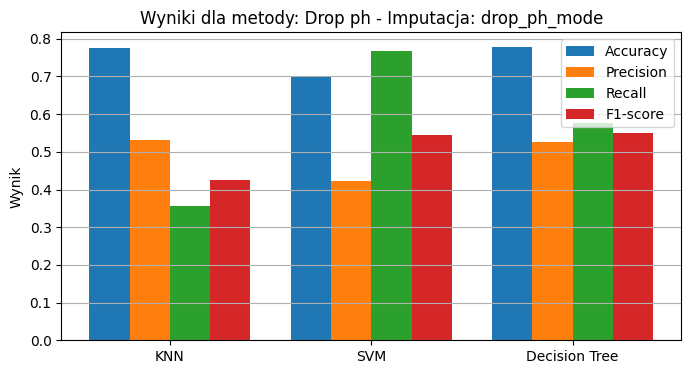


Wyniki dla metody: Drop ph - Imputacja: drop_ph_knn_5
KNN: Accuracy: 0.7873855544252288, Precision: 0.5647058823529412, Recall: 0.4155844155844156, F1-score: 0.47880299251870323
SVM: Accuracy: 0.6958290946083419, Precision: 0.42018779342723006, Recall: 0.7748917748917749, F1-score: 0.5449010654490106
Decision Tree: Accuracy: 0.7670396744659207, Precision: 0.5040983606557377, Recall: 0.5324675324675324, F1-score: 0.5178947368421053


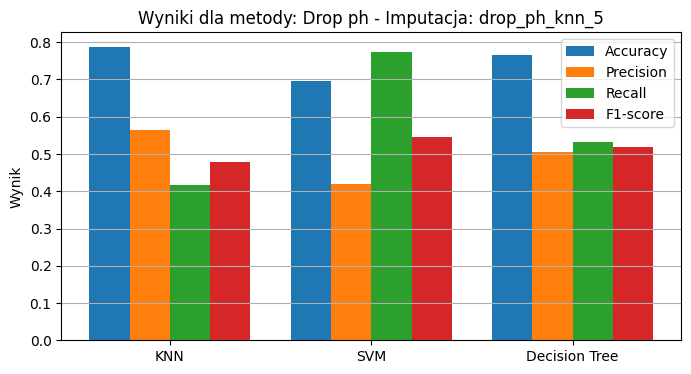


Wyniki dla metody: Drop ph - Imputacja: drop_ph_knn_10
KNN: Accuracy: 0.7721261444557477, Precision: 0.5214723926380368, Recall: 0.36796536796536794, F1-score: 0.43147208121827413
SVM: Accuracy: 0.698880976602238, Precision: 0.4231678486997636, Recall: 0.7748917748917749, F1-score: 0.5474006116207951
Decision Tree: Accuracy: 0.7721261444557477, Precision: 0.5137254901960784, Recall: 0.5670995670995671, F1-score: 0.5390946502057613


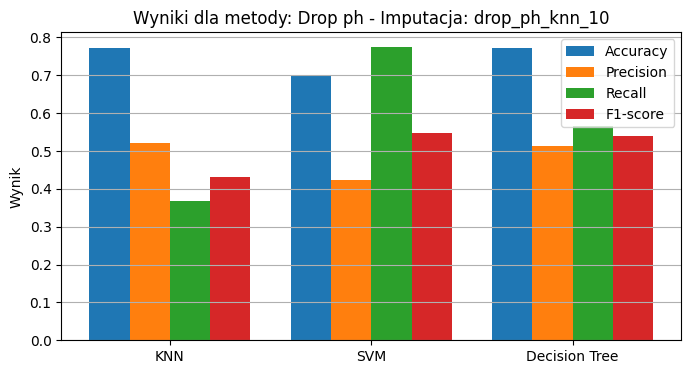


Wyniki dla metody: Drop ph - Imputacja: drop_ph_knn_20
KNN: Accuracy: 0.7822990844354019, Precision: 0.5502958579881657, Recall: 0.4025974025974026, F1-score: 0.465
SVM: Accuracy: 0.7009155645981688, Precision: 0.425531914893617, Recall: 0.7792207792207793, F1-score: 0.5504587155963303
Decision Tree: Accuracy: 0.7721261444557477, Precision: 0.5137254901960784, Recall: 0.5670995670995671, F1-score: 0.5390946502057613


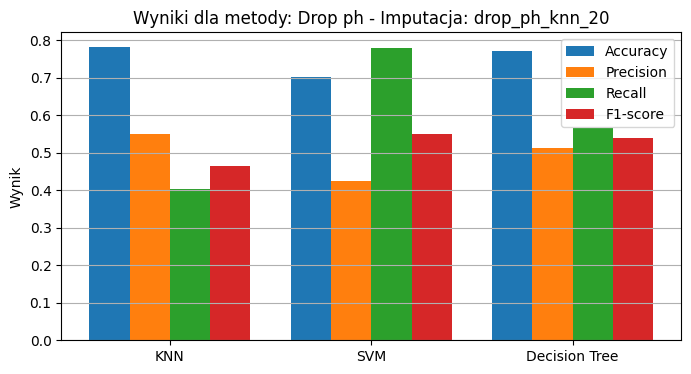


Wyniki dla metody: Drop ph - Imputacja: drop_ph_iter_10
KNN: Accuracy: 0.7833163784333672, Precision: 0.5548780487804879, Recall: 0.3939393939393939, F1-score: 0.4607594936708861
SVM: Accuracy: 0.698880976602238, Precision: 0.4238875878220141, Recall: 0.7835497835497836, F1-score: 0.5501519756838906
Decision Tree: Accuracy: 0.7721261444557477, Precision: 0.5139442231075697, Recall: 0.5584415584415584, F1-score: 0.5352697095435685


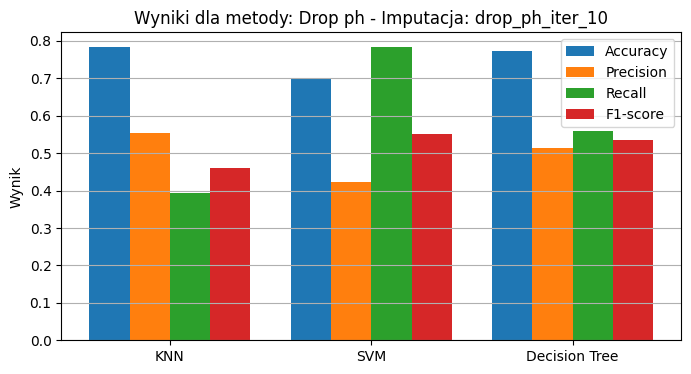


Wyniki dla metody: Drop ph - Imputacja: drop_ph_iter_20
KNN: Accuracy: 0.7833163784333672, Precision: 0.5548780487804879, Recall: 0.3939393939393939, F1-score: 0.4607594936708861
SVM: Accuracy: 0.698880976602238, Precision: 0.4238875878220141, Recall: 0.7835497835497836, F1-score: 0.5501519756838906
Decision Tree: Accuracy: 0.7721261444557477, Precision: 0.5141700404858299, Recall: 0.5497835497835498, F1-score: 0.5313807531380753


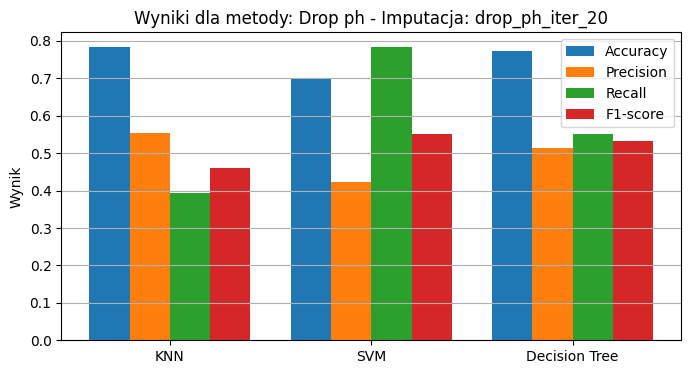


Wyniki dla metody: Drop ph - Imputacja: drop_ph_iter_dt
KNN: Accuracy: 0.7812817904374364, Precision: 0.5476190476190477, Recall: 0.39826839826839827, F1-score: 0.46115288220551376
SVM: Accuracy: 0.7009155645981688, Precision: 0.425531914893617, Recall: 0.7792207792207793, F1-score: 0.5504587155963303
Decision Tree: Accuracy: 0.7639877924720244, Precision: 0.497907949790795, Recall: 0.5151515151515151, F1-score: 0.5063829787234042


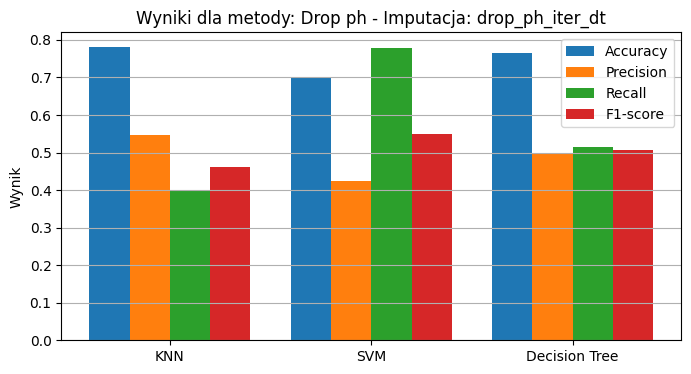


Wyniki dla metody: Drop ph - Imputacja: drop_ph_iter_rf
KNN: Accuracy: 0.7731434384537131, Precision: 0.5235294117647059, Recall: 0.3852813852813853, F1-score: 0.44389027431421446
SVM: Accuracy: 0.7009155645981688, Precision: 0.4258823529411765, Recall: 0.7835497835497836, F1-score: 0.551829268292683
Decision Tree: Accuracy: 0.7761953204476093, Precision: 0.5202952029520295, Recall: 0.6103896103896104, F1-score: 0.5617529880478087


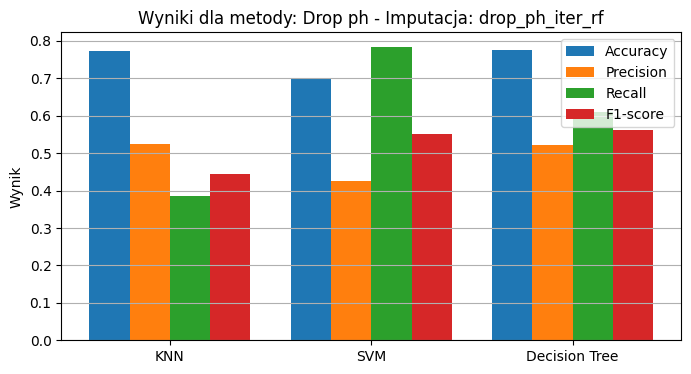


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_mean
KNN: Accuracy: 0.82706002034588, Precision: 0.6532663316582915, Recall: 0.5627705627705628, F1-score: 0.6046511627906976
SVM: Accuracy: 0.7049847405900305, Precision: 0.4275184275184275, Recall: 0.7532467532467533, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.8606307222787386, Precision: 0.7303921568627451, Recall: 0.645021645021645, F1-score: 0.6850574712643678


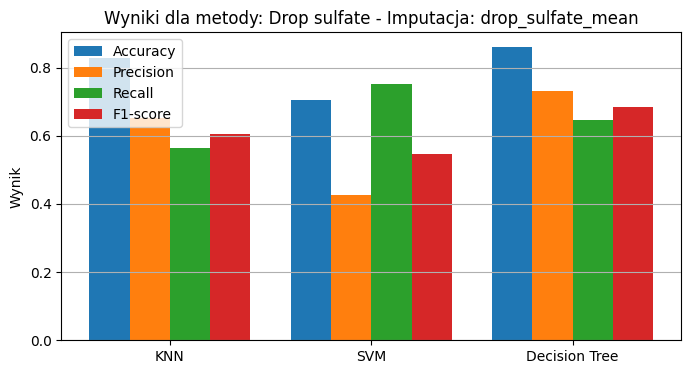


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_median
KNN: Accuracy: 0.8260427263479145, Precision: 0.65, Recall: 0.5627705627705628, F1-score: 0.6032482598607889
SVM: Accuracy: 0.7049847405900305, Precision: 0.4275184275184275, Recall: 0.7532467532467533, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.8606307222787386, Precision: 0.7303921568627451, Recall: 0.645021645021645, F1-score: 0.6850574712643678


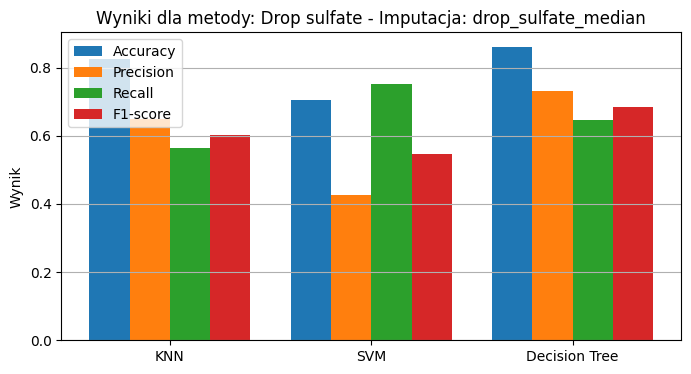


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_mode
KNN: Accuracy: 0.8097660223804679, Precision: 0.6122448979591837, Recall: 0.5194805194805194, F1-score: 0.5620608899297423
SVM: Accuracy: 0.6998982706002035, Precision: 0.4252336448598131, Recall: 0.7878787878787878, F1-score: 0.5523520485584219
Decision Tree: Accuracy: 0.8860630722278738, Precision: 0.8020304568527918, Recall: 0.683982683982684, F1-score: 0.7383177570093458


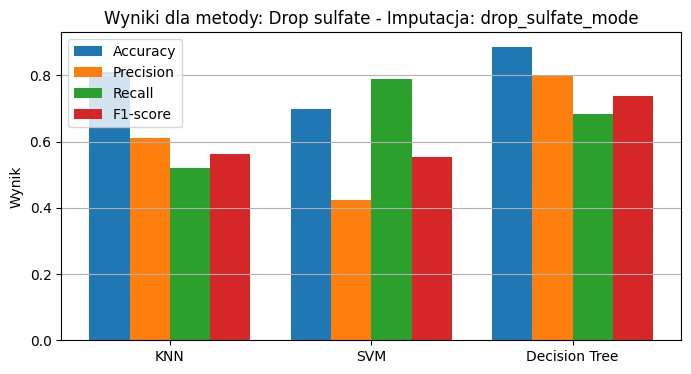


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_knn_5
KNN: Accuracy: 0.8229908443540183, Precision: 0.6524064171122995, Recall: 0.5281385281385281, F1-score: 0.583732057416268
SVM: Accuracy: 0.7049847405900305, Precision: 0.4275184275184275, Recall: 0.7532467532467533, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.8728382502543235, Precision: 0.7880434782608695, Recall: 0.6277056277056277, F1-score: 0.6987951807228916


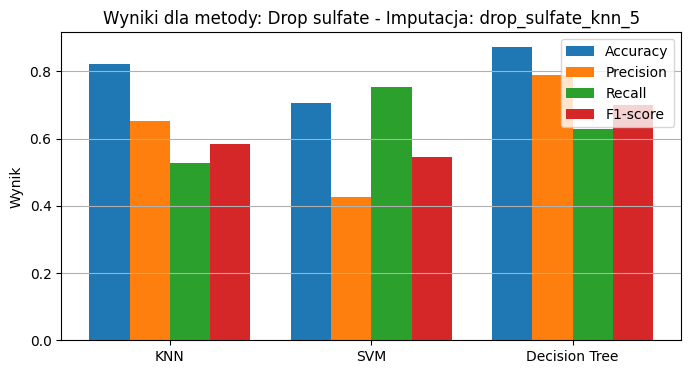


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_knn_10
KNN: Accuracy: 0.8290946083418108, Precision: 0.6666666666666666, Recall: 0.5454545454545454, F1-score: 0.6
SVM: Accuracy: 0.7060020345879959, Precision: 0.42857142857142855, Recall: 0.7532467532467533, F1-score: 0.5463108320251178
Decision Tree: Accuracy: 0.8646998982706002, Precision: 0.7474747474747475, Recall: 0.6406926406926406, F1-score: 0.6899766899766899


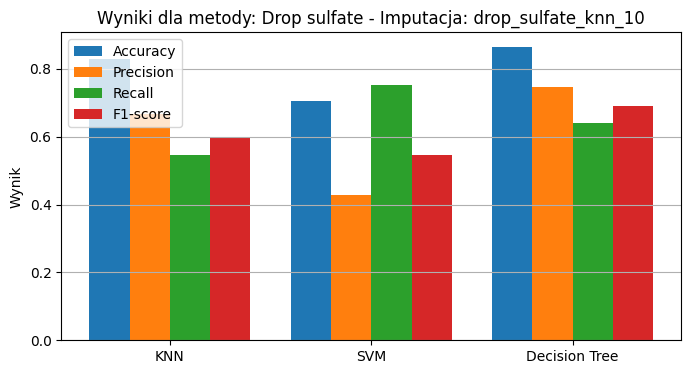


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_knn_20
KNN: Accuracy: 0.8209562563580874, Precision: 0.6381909547738693, Recall: 0.5497835497835498, F1-score: 0.5906976744186047
SVM: Accuracy: 0.7070193285859614, Precision: 0.43031784841075793, Recall: 0.7619047619047619, F1-score: 0.55
Decision Tree: Accuracy: 0.866734486266531, Precision: 0.7551020408163265, Recall: 0.6406926406926406, F1-score: 0.6932084309133489


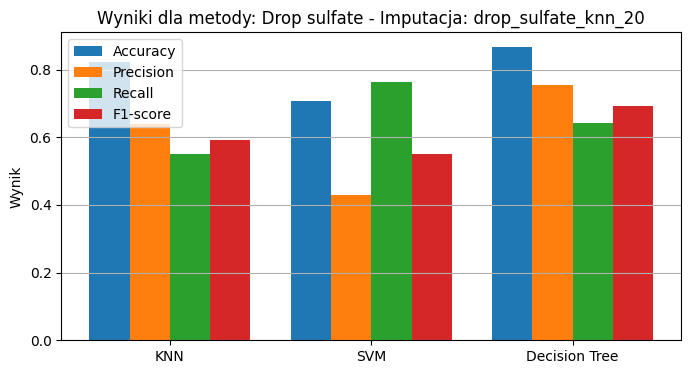


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_iter_10
KNN: Accuracy: 0.8209562563580874, Precision: 0.6424870466321243, Recall: 0.5367965367965368, F1-score: 0.5849056603773585
SVM: Accuracy: 0.7049847405900305, Precision: 0.4275184275184275, Recall: 0.7532467532467533, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.8596134282807731, Precision: 0.7313432835820896, Recall: 0.6363636363636364, F1-score: 0.6805555555555556


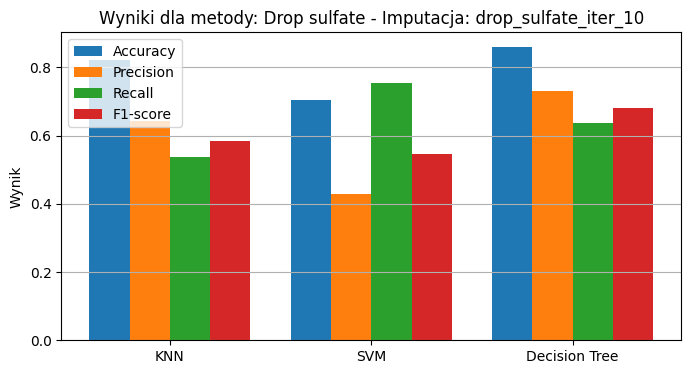


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_iter_20
KNN: Accuracy: 0.8209562563580874, Precision: 0.6424870466321243, Recall: 0.5367965367965368, F1-score: 0.5849056603773585
SVM: Accuracy: 0.7049847405900305, Precision: 0.4275184275184275, Recall: 0.7532467532467533, F1-score: 0.5454545454545454
Decision Tree: Accuracy: 0.8596134282807731, Precision: 0.7313432835820896, Recall: 0.6363636363636364, F1-score: 0.6805555555555556


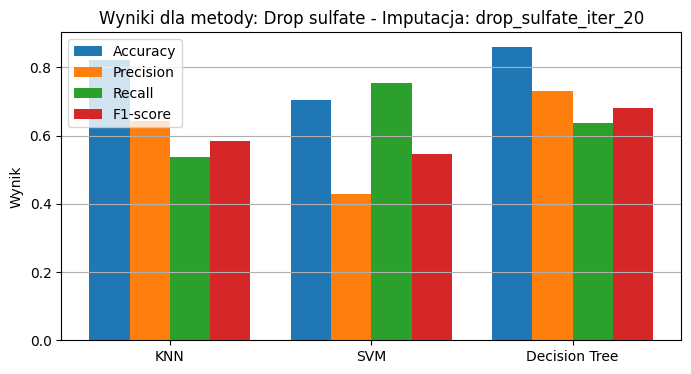


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_iter_dt
KNN: Accuracy: 0.8250254323499492, Precision: 0.6512820512820513, Recall: 0.5497835497835498, F1-score: 0.596244131455399
SVM: Accuracy: 0.7070193285859614, Precision: 0.42997542997543, Recall: 0.7575757575757576, F1-score: 0.54858934169279
Decision Tree: Accuracy: 0.8596134282807731, Precision: 0.7313432835820896, Recall: 0.6363636363636364, F1-score: 0.6805555555555556


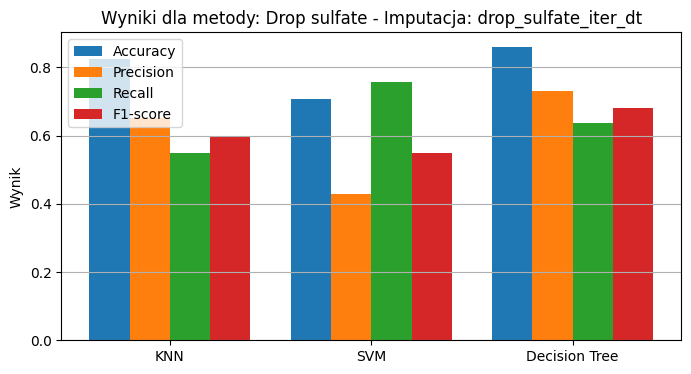


Wyniki dla metody: Drop sulfate - Imputacja: drop_sulfate_iter_rf
KNN: Accuracy: 0.8240081383519837, Precision: 0.6435643564356436, Recall: 0.5627705627705628, F1-score: 0.6004618937644342
SVM: Accuracy: 0.7070193285859614, Precision: 0.42997542997543, Recall: 0.7575757575757576, F1-score: 0.54858934169279
Decision Tree: Accuracy: 0.873855544252289, Precision: 0.7955801104972375, Recall: 0.6233766233766234, F1-score: 0.6990291262135923


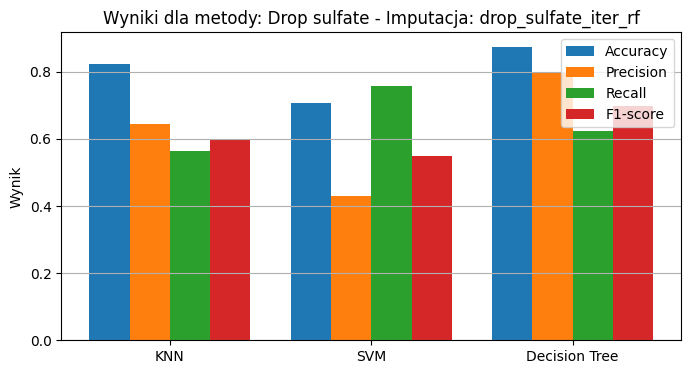


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_mean
KNN: Accuracy: 0.8026449643947101, Precision: 0.5989304812834224, Recall: 0.48484848484848486, F1-score: 0.5358851674641149
SVM: Accuracy: 0.6846388606307223, Precision: 0.4096109839816934, Recall: 0.7748917748917749, F1-score: 0.5359281437125748
Decision Tree: Accuracy: 0.8362156663275687, Precision: 0.65625, Recall: 0.6363636363636364, F1-score: 0.6461538461538462


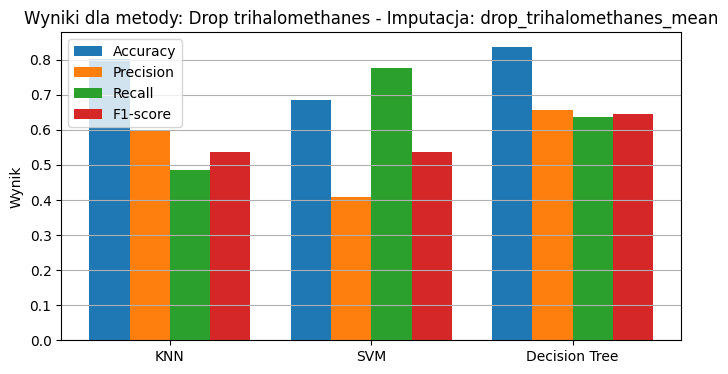


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_median
KNN: Accuracy: 0.8006103763987793, Precision: 0.5925925925925926, Recall: 0.48484848484848486, F1-score: 0.5333333333333333
SVM: Accuracy: 0.6836215666327569, Precision: 0.408675799086758, Recall: 0.7748917748917749, F1-score: 0.5351270553064275
Decision Tree: Accuracy: 0.8362156663275687, Precision: 0.65625, Recall: 0.6363636363636364, F1-score: 0.6461538461538462


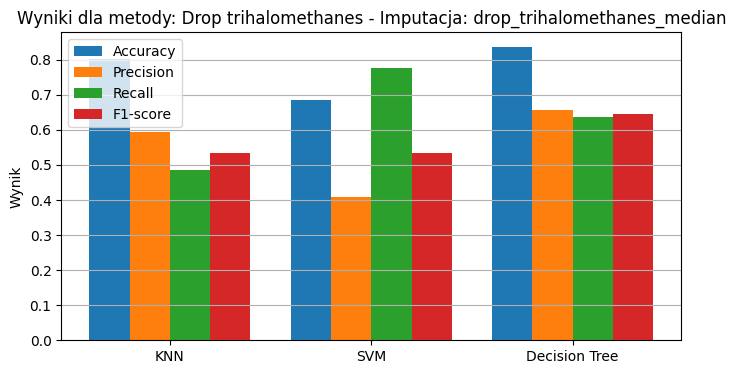


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_mode
KNN: Accuracy: 0.785350966429298, Precision: 0.5574712643678161, Recall: 0.4199134199134199, F1-score: 0.47901234567901235
SVM: Accuracy: 0.6866734486266531, Precision: 0.4123006833712984, Recall: 0.7835497835497836, F1-score: 0.5402985074626866
Decision Tree: Accuracy: 0.8392675483214649, Precision: 0.689119170984456, Recall: 0.5757575757575758, F1-score: 0.6273584905660378


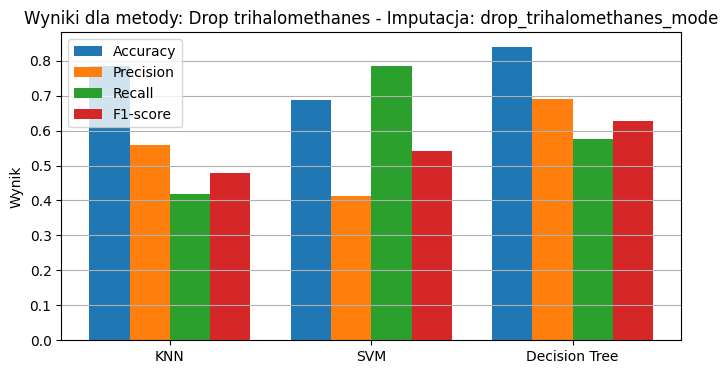


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_knn_5
KNN: Accuracy: 0.7985757884028484, Precision: 0.5901639344262295, Recall: 0.4675324675324675, F1-score: 0.5217391304347826
SVM: Accuracy: 0.6866734486266531, Precision: 0.4110854503464203, Recall: 0.7705627705627706, F1-score: 0.536144578313253
Decision Tree: Accuracy: 0.8362156663275687, Precision: 0.6732673267326733, Recall: 0.5887445887445888, F1-score: 0.628175519630485


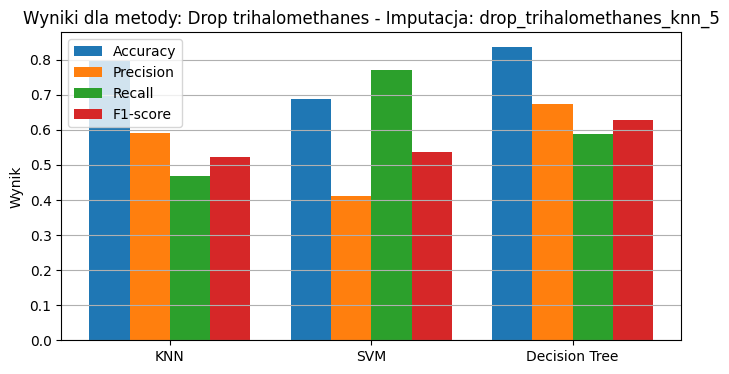


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_knn_10
KNN: Accuracy: 0.7965412004069176, Precision: 0.5803108808290155, Recall: 0.48484848484848486, F1-score: 0.5283018867924528
SVM: Accuracy: 0.6846388606307223, Precision: 0.4091954022988506, Recall: 0.7705627705627706, F1-score: 0.5345345345345346
Decision Tree: Accuracy: 0.8382502543234995, Precision: 0.6698113207547169, Recall: 0.6147186147186147, F1-score: 0.6410835214446953


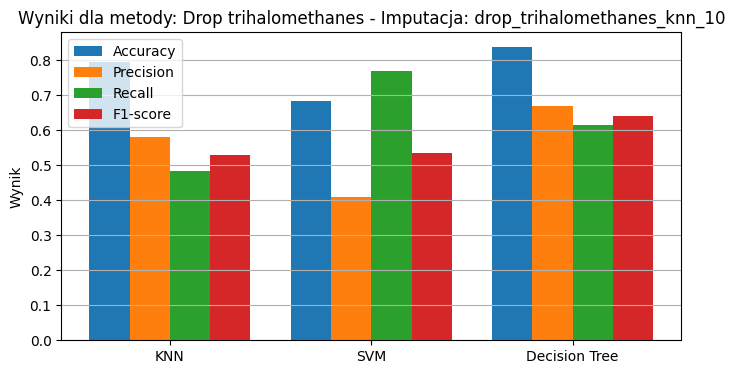


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_knn_20
KNN: Accuracy: 0.8006103763987793, Precision: 0.5956284153005464, Recall: 0.47186147186147187, F1-score: 0.5265700483091788
SVM: Accuracy: 0.6866734486266531, Precision: 0.4114942528735632, Recall: 0.7748917748917749, F1-score: 0.5375375375375375
Decision Tree: Accuracy: 0.8433367243133265, Precision: 0.6790697674418604, Recall: 0.6320346320346321, F1-score: 0.6547085201793722


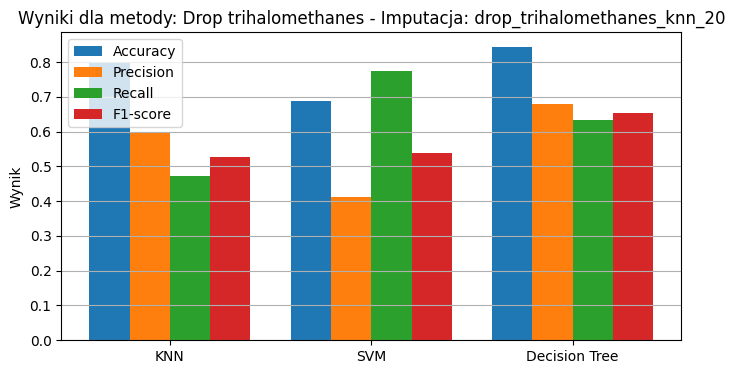


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_iter_10
KNN: Accuracy: 0.8046795523906409, Precision: 0.6077348066298343, Recall: 0.47619047619047616, F1-score: 0.5339805825242718
SVM: Accuracy: 0.6846388606307223, Precision: 0.4096109839816934, Recall: 0.7748917748917749, F1-score: 0.5359281437125748
Decision Tree: Accuracy: 0.8372329603255341, Precision: 0.6563876651982379, Recall: 0.645021645021645, F1-score: 0.6506550218340611


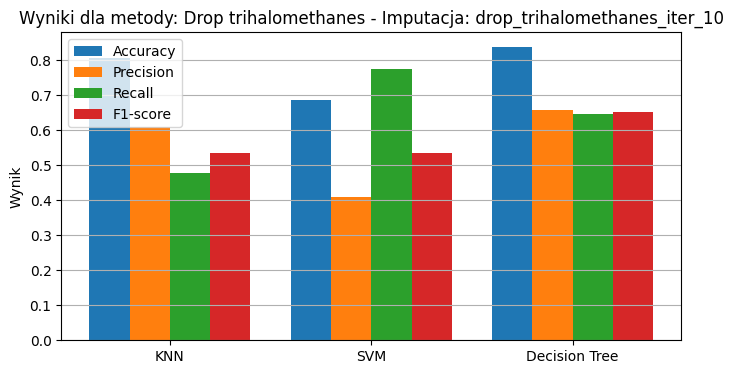


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_iter_20
KNN: Accuracy: 0.8046795523906409, Precision: 0.6077348066298343, Recall: 0.47619047619047616, F1-score: 0.5339805825242718
SVM: Accuracy: 0.6846388606307223, Precision: 0.4096109839816934, Recall: 0.7748917748917749, F1-score: 0.5359281437125748
Decision Tree: Accuracy: 0.8372329603255341, Precision: 0.6550218340611353, Recall: 0.6493506493506493, F1-score: 0.6521739130434783


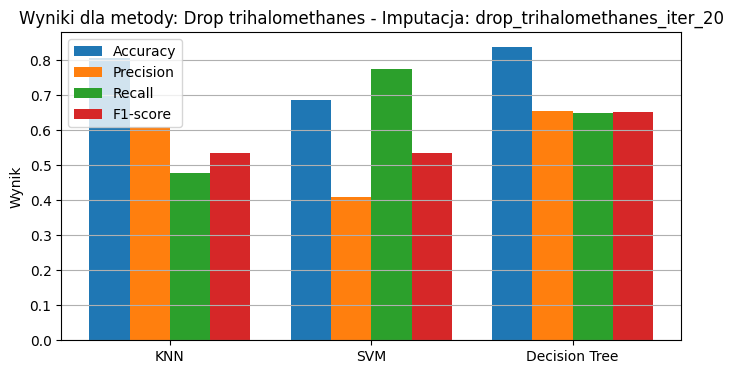


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_iter_dt
KNN: Accuracy: 0.8097660223804679, Precision: 0.6235955056179775, Recall: 0.4805194805194805, F1-score: 0.5427872860635696
SVM: Accuracy: 0.6846388606307223, Precision: 0.4096109839816934, Recall: 0.7748917748917749, F1-score: 0.5359281437125748
Decision Tree: Accuracy: 0.8392675483214649, Precision: 0.6682027649769585, Recall: 0.6277056277056277, F1-score: 0.6473214285714286


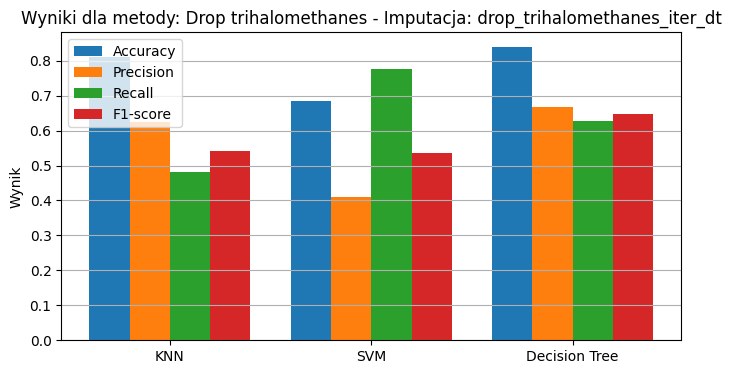


Wyniki dla metody: Drop trihalomethanes - Imputacja: drop_trihalomethanes_iter_rf
KNN: Accuracy: 0.8046795523906409, Precision: 0.6065573770491803, Recall: 0.4805194805194805, F1-score: 0.5362318840579711
SVM: Accuracy: 0.6866734486266531, Precision: 0.4110854503464203, Recall: 0.7705627705627706, F1-score: 0.536144578313253
Decision Tree: Accuracy: 0.8494404883011191, Precision: 0.7064676616915423, Recall: 0.6147186147186147, F1-score: 0.6574074074074074


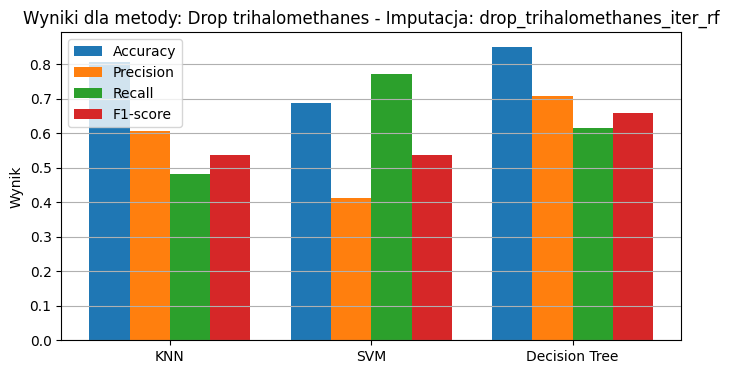


Wyniki dla metody: Drop all - Imputacja: drop_all_mean
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7599186164801628, Precision: 0.4873096446700508, Recall: 0.4155844155844156, F1-score: 0.4485981308411215


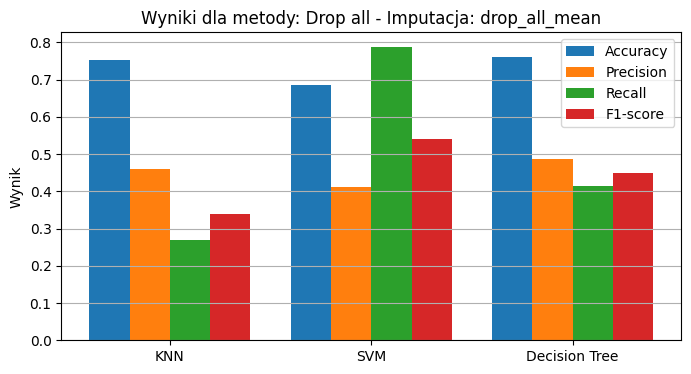


Wyniki dla metody: Drop all - Imputacja: drop_all_median
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7599186164801628, Precision: 0.4873096446700508, Recall: 0.4155844155844156, F1-score: 0.4485981308411215


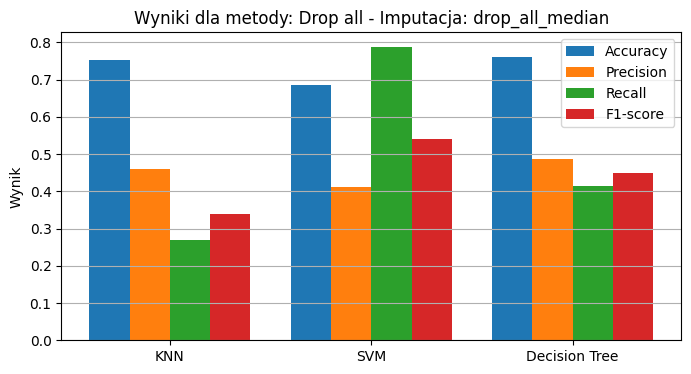


Wyniki dla metody: Drop all - Imputacja: drop_all_mode
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7568667344862665, Precision: 0.4797979797979798, Recall: 0.41125541125541126, F1-score: 0.4428904428904429


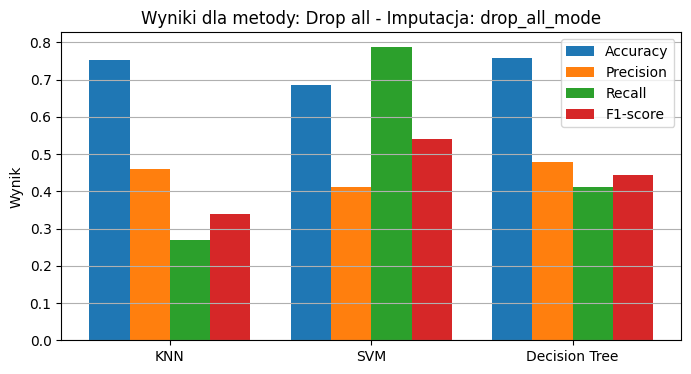


Wyniki dla metody: Drop all - Imputacja: drop_all_knn_5
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7568667344862665, Precision: 0.4797979797979798, Recall: 0.41125541125541126, F1-score: 0.4428904428904429


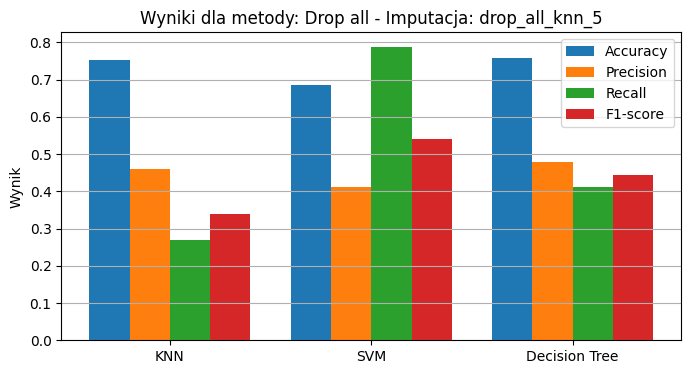


Wyniki dla metody: Drop all - Imputacja: drop_all_knn_10
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.757884028484232, Precision: 0.4824120603015075, Recall: 0.4155844155844156, F1-score: 0.44651162790697674


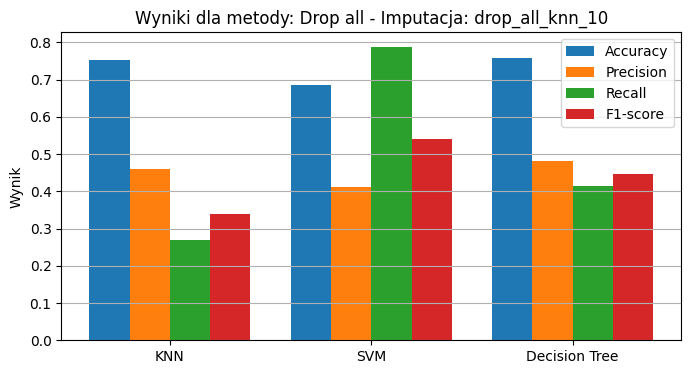


Wyniki dla metody: Drop all - Imputacja: drop_all_knn_20
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.757884028484232, Precision: 0.4824120603015075, Recall: 0.4155844155844156, F1-score: 0.44651162790697674


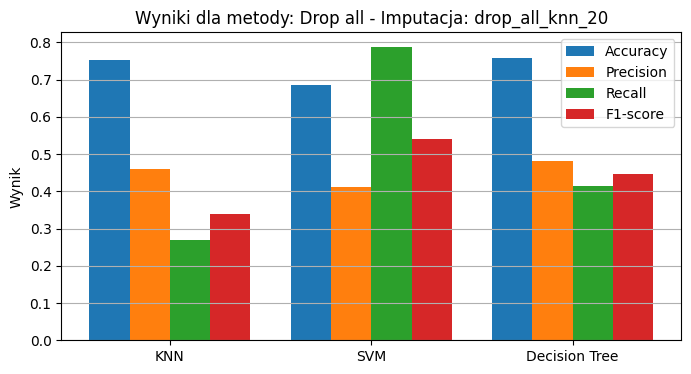


Wyniki dla metody: Drop all - Imputacja: drop_all_iter_10
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7619532044760936, Precision: 0.49230769230769234, Recall: 0.4155844155844156, F1-score: 0.4507042253521127


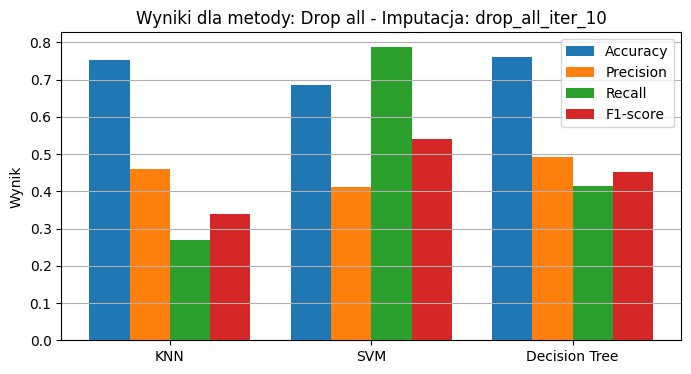


Wyniki dla metody: Drop all - Imputacja: drop_all_iter_20
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.757884028484232, Precision: 0.4824120603015075, Recall: 0.4155844155844156, F1-score: 0.44651162790697674


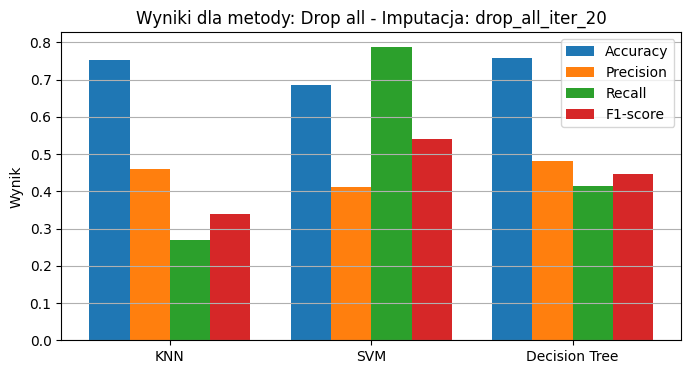


Wyniki dla metody: Drop all - Imputacja: drop_all_iter_dt
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7619532044760936, Precision: 0.49230769230769234, Recall: 0.4155844155844156, F1-score: 0.4507042253521127


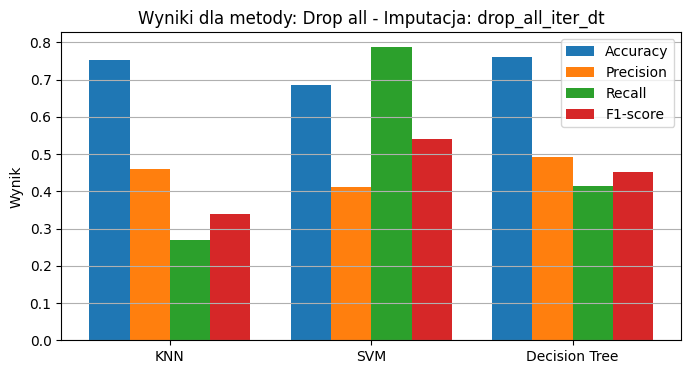


Wyniki dla metody: Drop all - Imputacja: drop_all_iter_rf
KNN: Accuracy: 0.7538148524923703, Precision: 0.45925925925925926, Recall: 0.2683982683982684, F1-score: 0.33879781420765026
SVM: Accuracy: 0.6846388606307223, Precision: 0.4108352144469526, Recall: 0.7878787878787878, F1-score: 0.5400593471810089
Decision Tree: Accuracy: 0.7609359104781281, Precision: 0.4897959183673469, Recall: 0.4155844155844156, F1-score: 0.4496487119437939


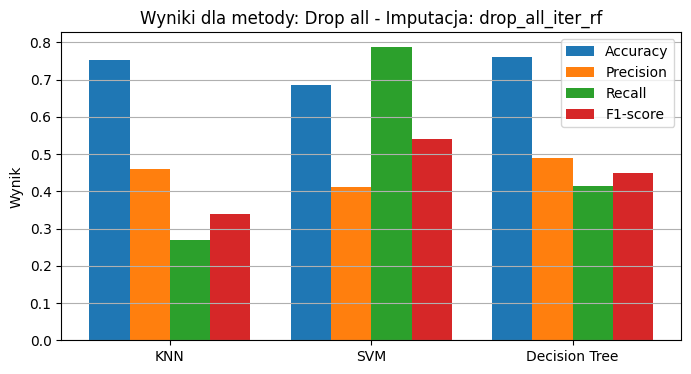

In [85]:
# Tworzenie podstawowych zbiorów danych po usunięciu kolumn
df_drop = df.dropna()
df_drop_ph = df.drop(columns=["ph"])
df_drop_sulfate = df.drop(columns=["Sulfate"])
df_drop_trihalomethanes = df.drop(columns=["Trihalomethanes"])
df_drop_all = df.drop(columns=["ph", "Sulfate", "Trihalomethanes"])

# Funkcja do tworzenia skopiowanych danych i imputacji
def create_imputed_datasets(base_df, name):
    imputed_datasets = {}
    imputers = {
        "mean": SimpleImputer(strategy="mean"),
        "median": SimpleImputer(strategy="median"),
        "mode": SimpleImputer(strategy="most_frequent"),
        "knn_5": KNNImputer(n_neighbors=5),
        "knn_10": KNNImputer(n_neighbors=10),
        "knn_20": KNNImputer(n_neighbors=20),
        "iter_10": IterativeImputer(max_iter=10, random_state=42),
        "iter_20": IterativeImputer(max_iter=20, random_state=42),
        "iter_dt": IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), random_state=42),
        "iter_rf": IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)
    }

    for method, imputer in imputers.items():
        df_imputed = base_df.copy()
        df_imputed.iloc[:, :-1] = imputer.fit_transform(df_imputed.iloc[:, :-1])
        scaler = MinMaxScaler()
        df_imputed.iloc[:, :-1] = scaler.fit_transform(df_imputed.iloc[:, :-1])
        imputed_datasets[f"{name}_{method}"] = df_imputed

    return imputed_datasets

# Tworzenie zbiorów danych z imputacją dla każdego przypadku usuniętej kolumny
datasets = {
    "Drop": {"df": df_drop},
    "Drop ph": create_imputed_datasets(df_drop_ph, "drop_ph"),
    "Drop sulfate": create_imputed_datasets(df_drop_sulfate, "drop_sulfate"),
    "Drop trihalomethanes": create_imputed_datasets(df_drop_trihalomethanes, "drop_trihalomethanes"),
    "Drop all": create_imputed_datasets(df_drop_all, "drop_all")
}

# Tworzenie modelu
knn = KNeighborsClassifier(n_neighbors=7, weights="distance", metric="manhattan")
svm = SVC(kernel="rbf", C=10, gamma=0.1, class_weight='balanced')
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, criterion='entropy')

# Funkcja do treningu modelu
def train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1_metric

# Funkcja do podziału danych
def split_data(df):
    X = df.iloc[:, :-1].values  
    y = df.iloc[:, -1].values   
    return train_test_split(X, y, test_size=0.3, random_state=0)

# Trening i wyniki
for name, data in datasets.items():
    for impute_name, df in data.items():
        X_train, X_test, y_train, y_test = split_data(df)
        print(f"\nWyniki dla metody: {name} - Imputacja: {impute_name}")

        acc_knn, prec_knn, recall_knn, f1_knn = train(knn, X_train, X_test, y_train, y_test)
        print(f"KNN: Accuracy: {acc_knn}, Precision: {prec_knn}, Recall: {recall_knn}, F1-score: {f1_knn}")

        acc_svm, prec_svm, recall_svm, f1_svm = train(svm, X_train, X_test, y_train, y_test)
        print(f"SVM: Accuracy: {acc_svm}, Precision: {prec_svm}, Recall: {recall_svm}, F1-score: {f1_svm}")

        acc_dt, prec_dt, recall_dt, f1_dt = train(dt, X_train, X_test, y_train, y_test)
        print(f"Decision Tree: Accuracy: {acc_dt}, Precision: {prec_dt}, Recall: {recall_dt}, F1-score: {f1_dt}")

        # Wykresy
        labels = ["KNN", "SVM", "Decision Tree"]
        accuracy = [acc_knn, acc_svm, acc_dt]
        precision = [prec_knn, prec_svm, prec_dt]
        recall = [recall_knn, recall_svm, recall_dt]
        f1_scores = [f1_knn, f1_svm, f1_dt]

        metrics = [accuracy, precision, recall, f1_scores]
        metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]

        plt.figure(figsize=(8, 4))

        for i, metric in enumerate(metrics):
            plt.bar([x + i * 0.2 for x in range(len(labels))], metric, width=0.2, label=metric_names[i])

        plt.xticks([x + 0.3 for x in range(len(labels))], labels)
        plt.ylabel("Wynik")
        plt.title(f"Wyniki dla metody: {name} - Imputacja: {impute_name}")
        plt.legend()
        plt.grid(axis="y")
        plt.show()


Porównanie metod imputacji dla wybranych cech

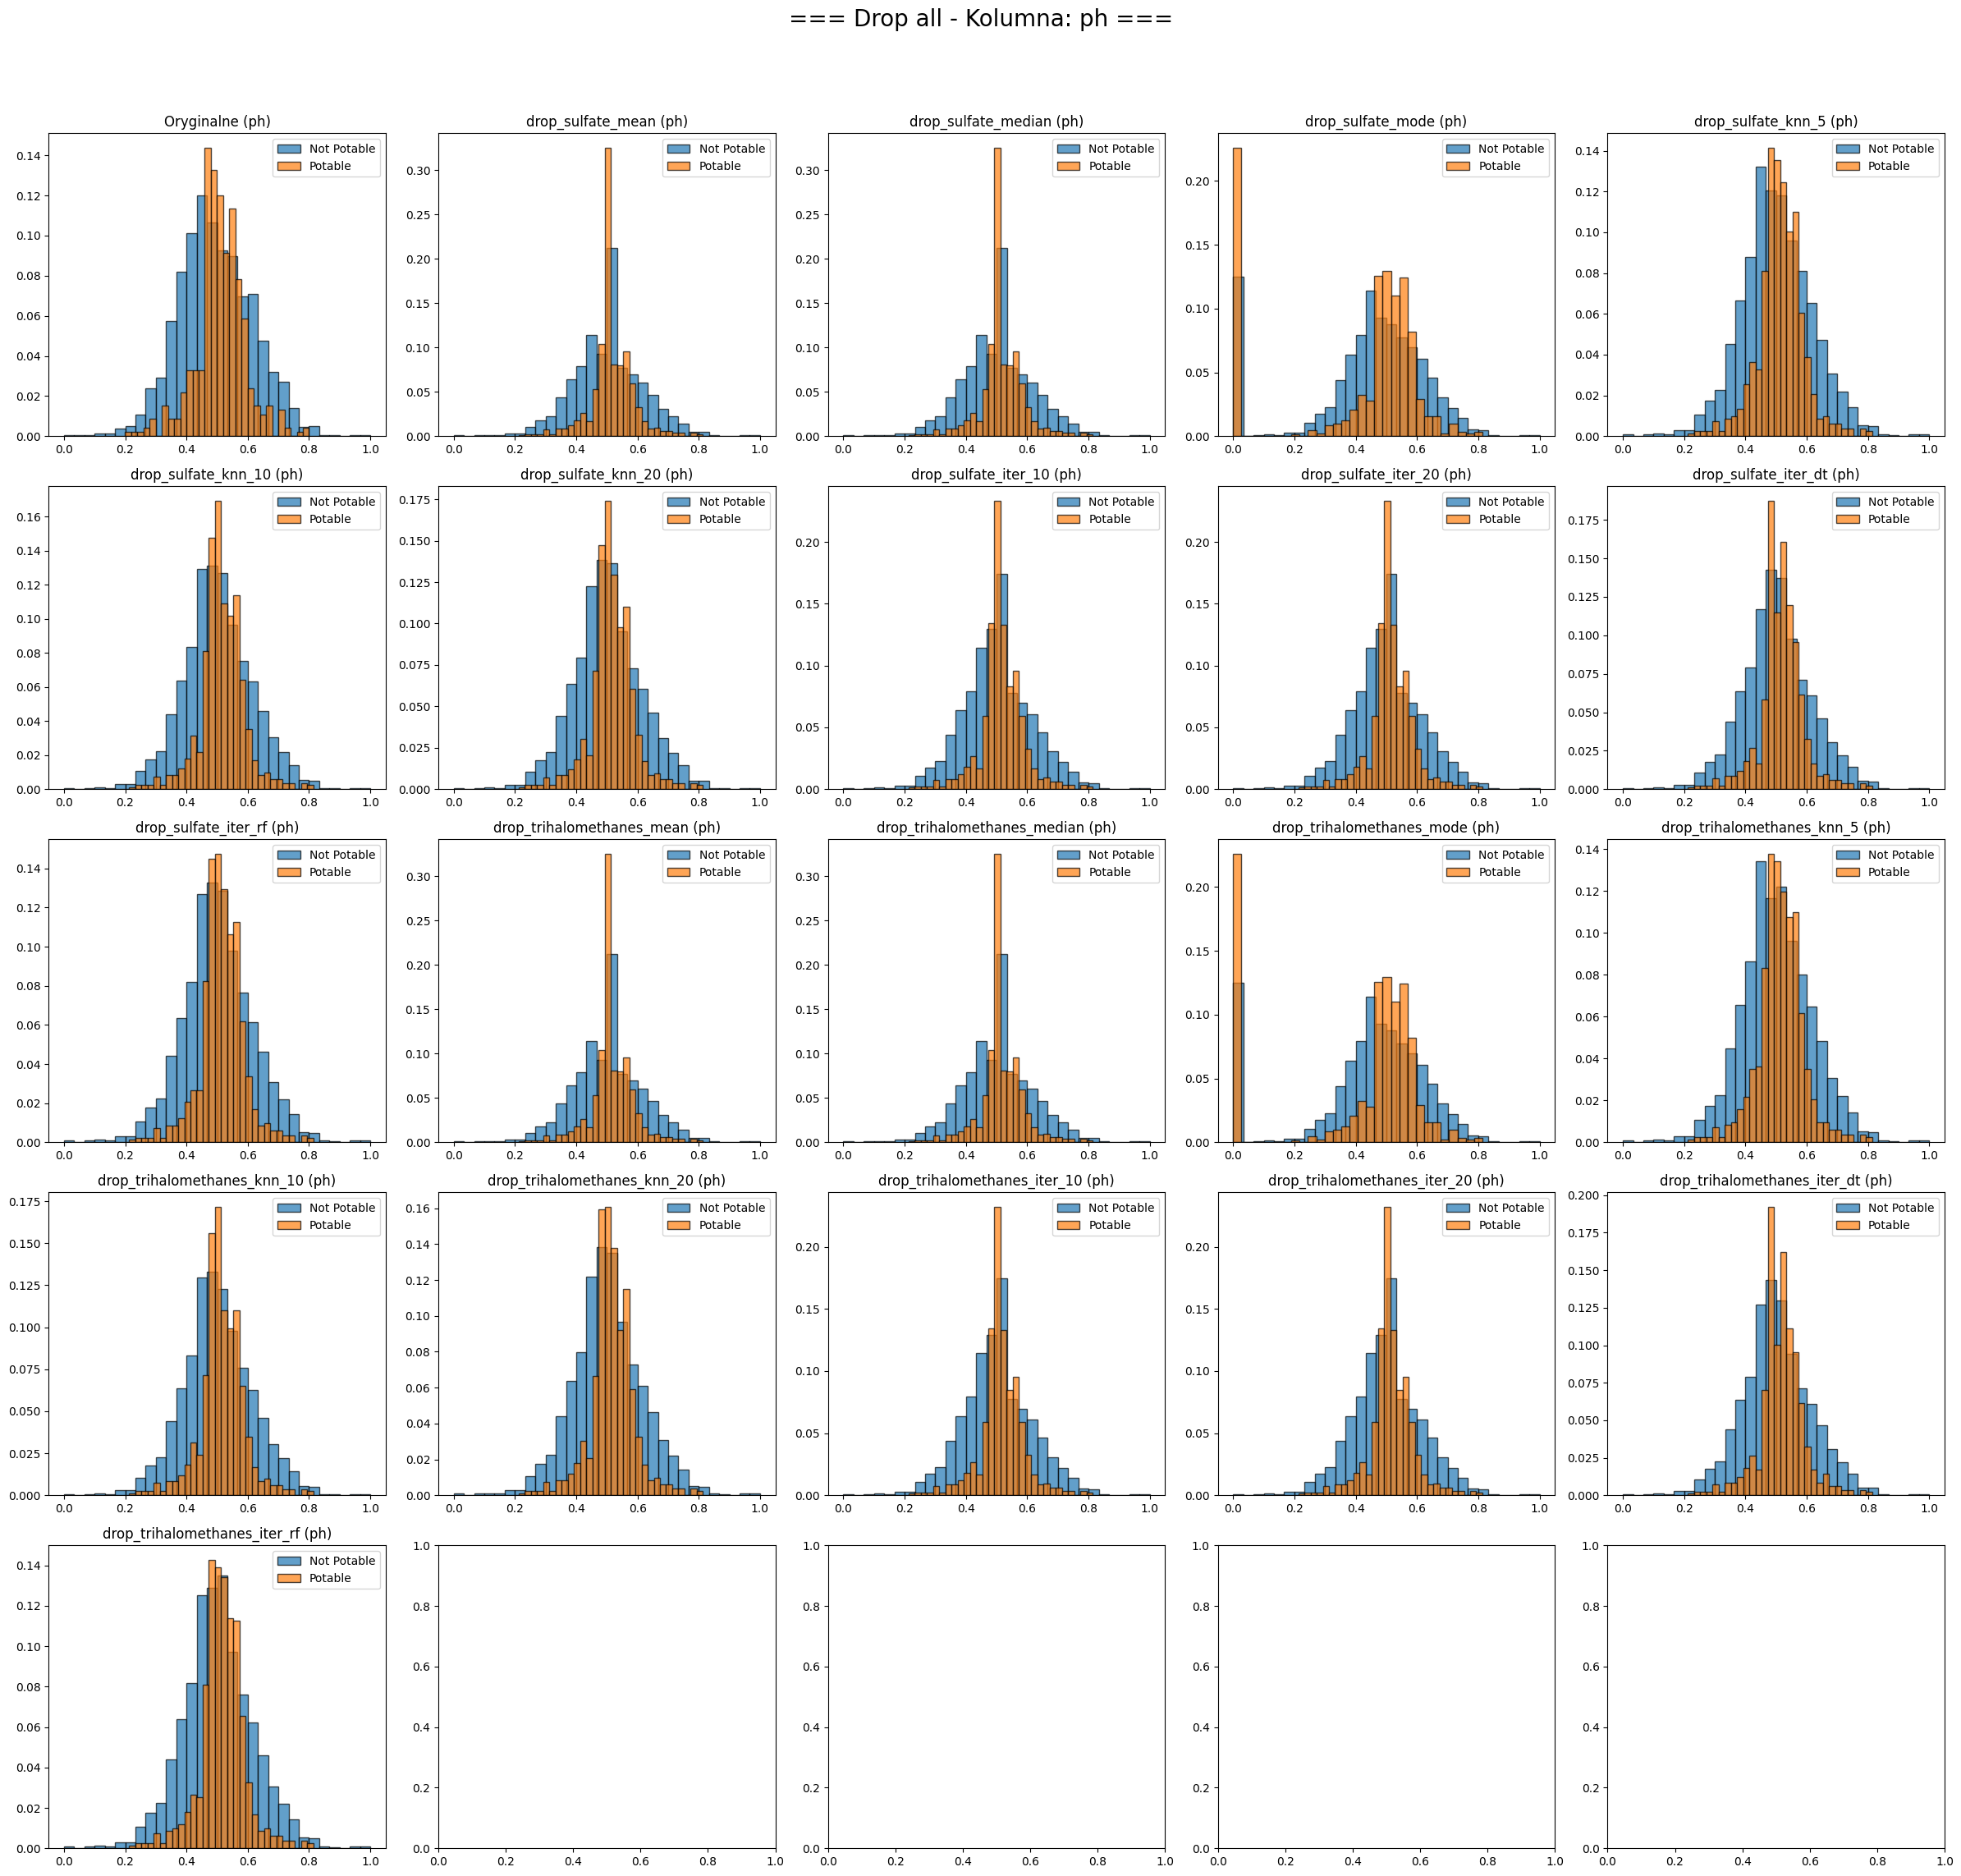

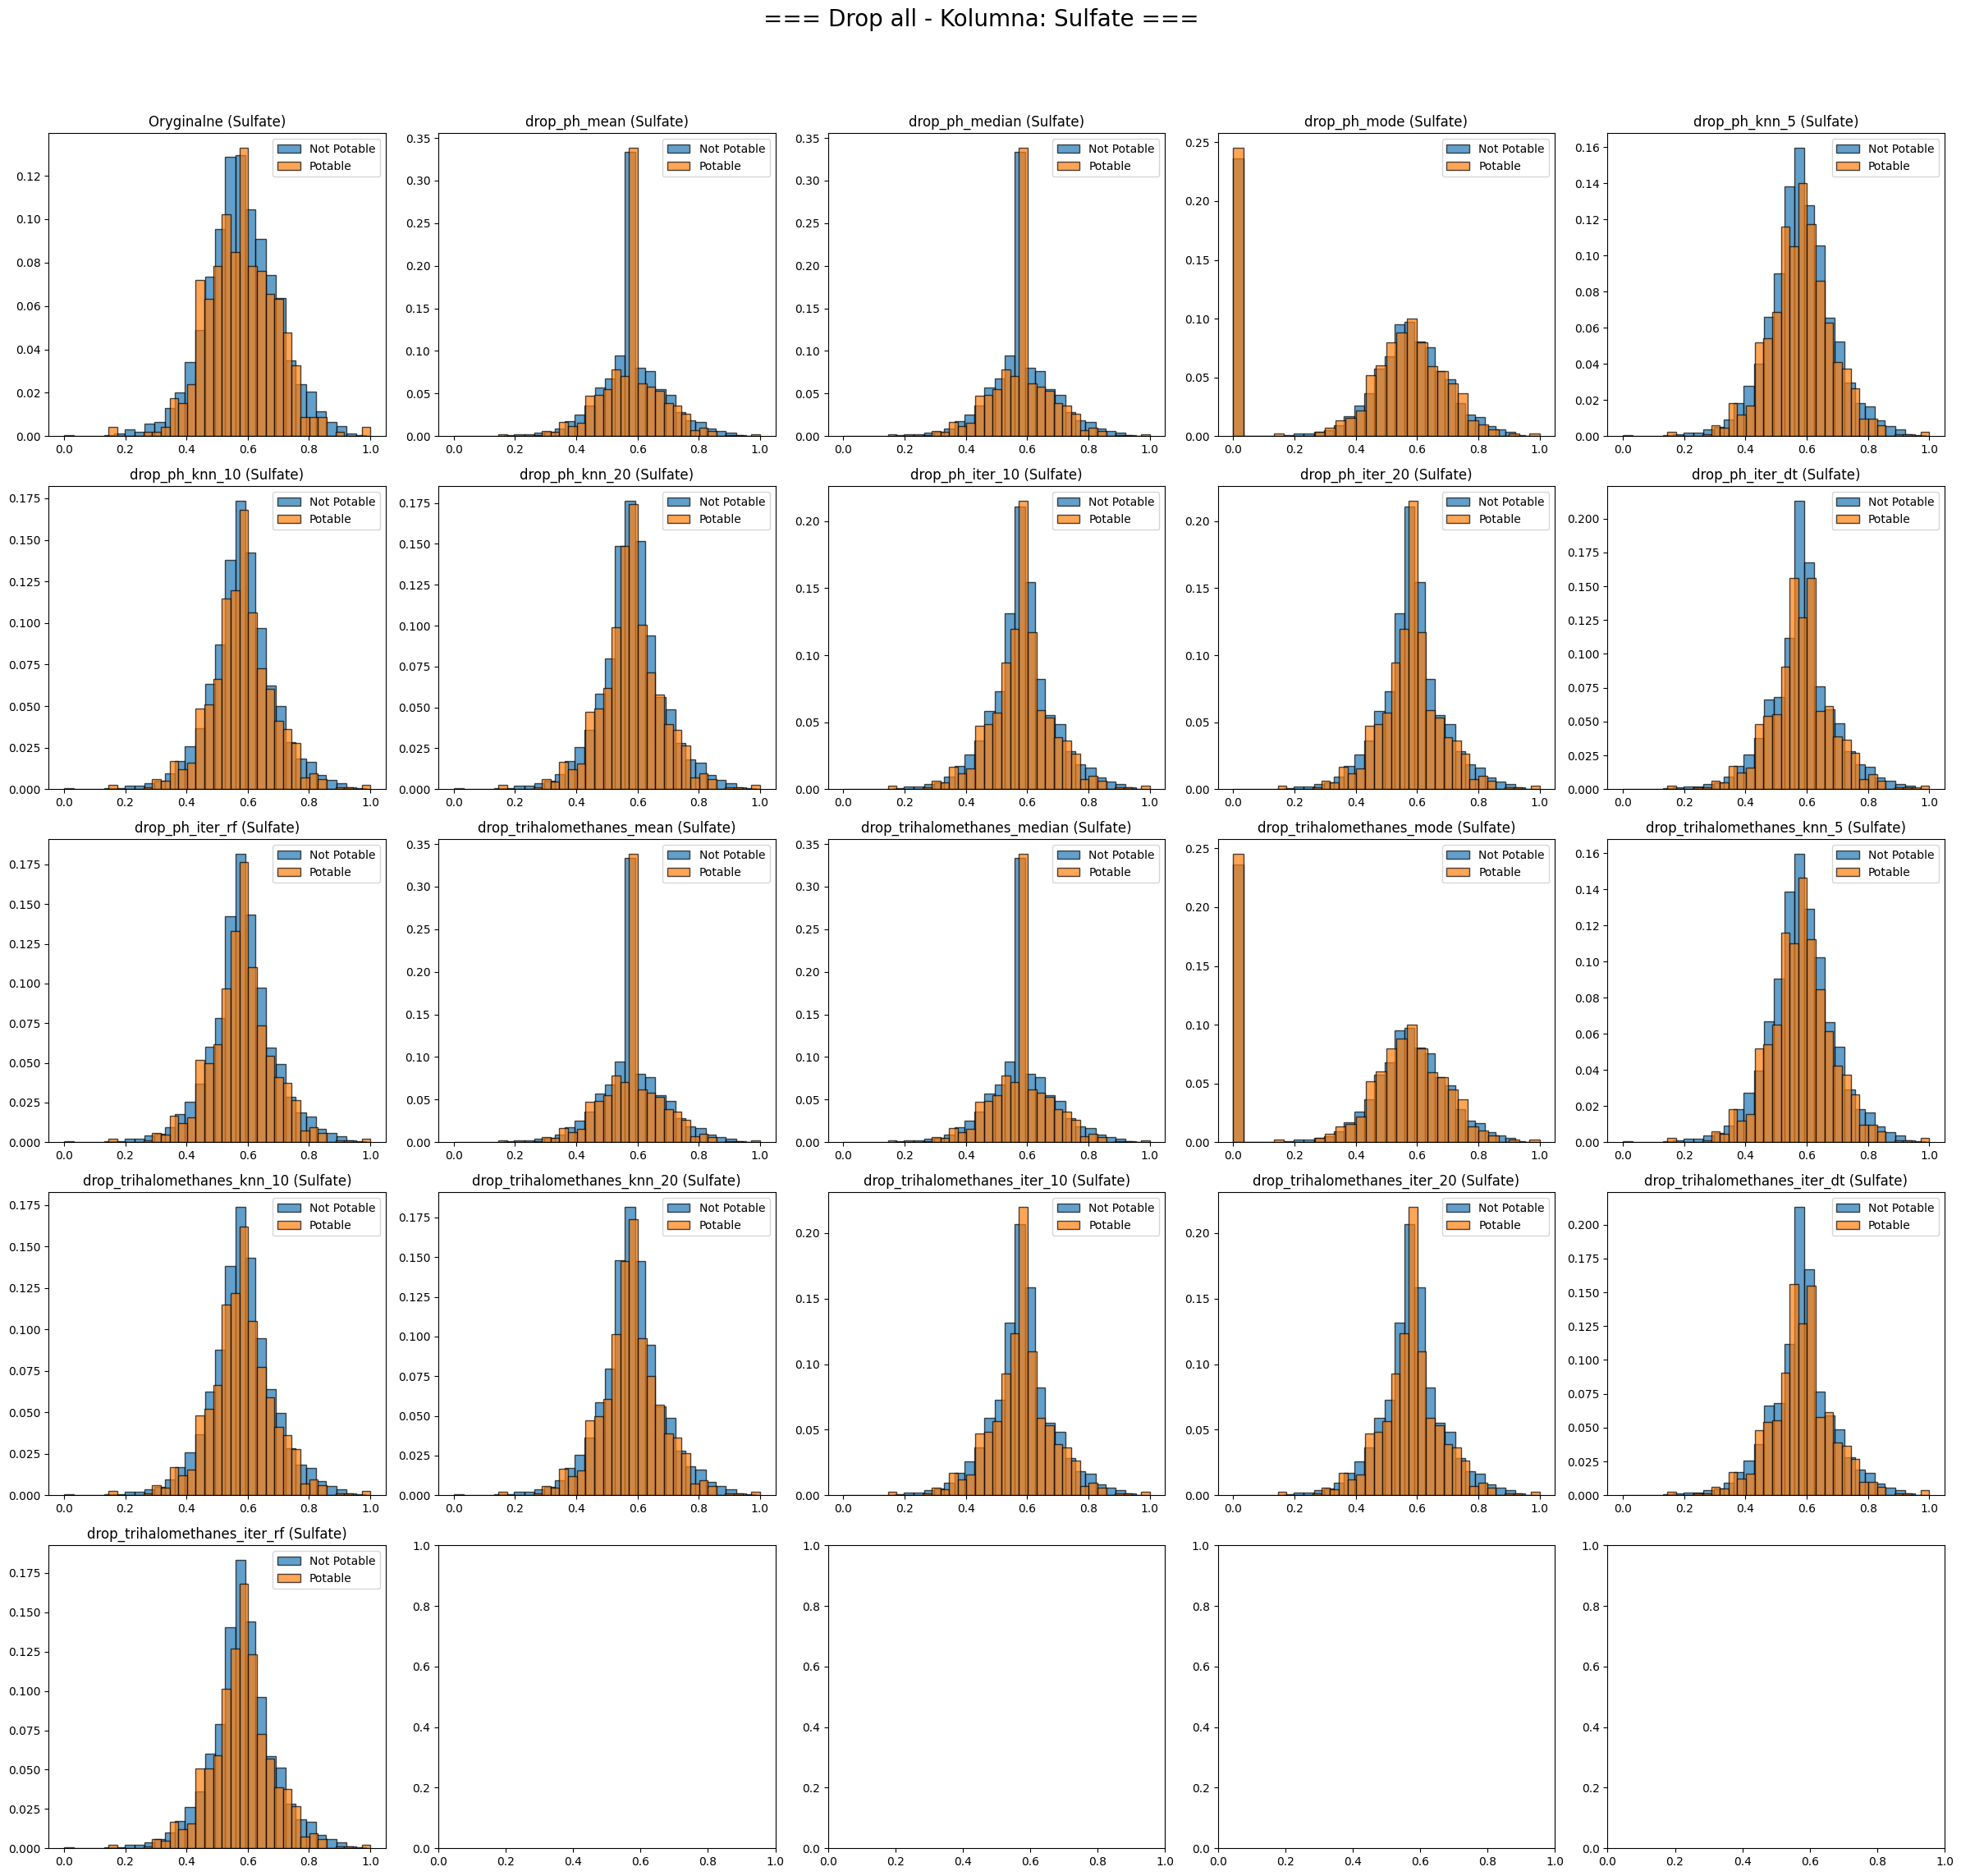

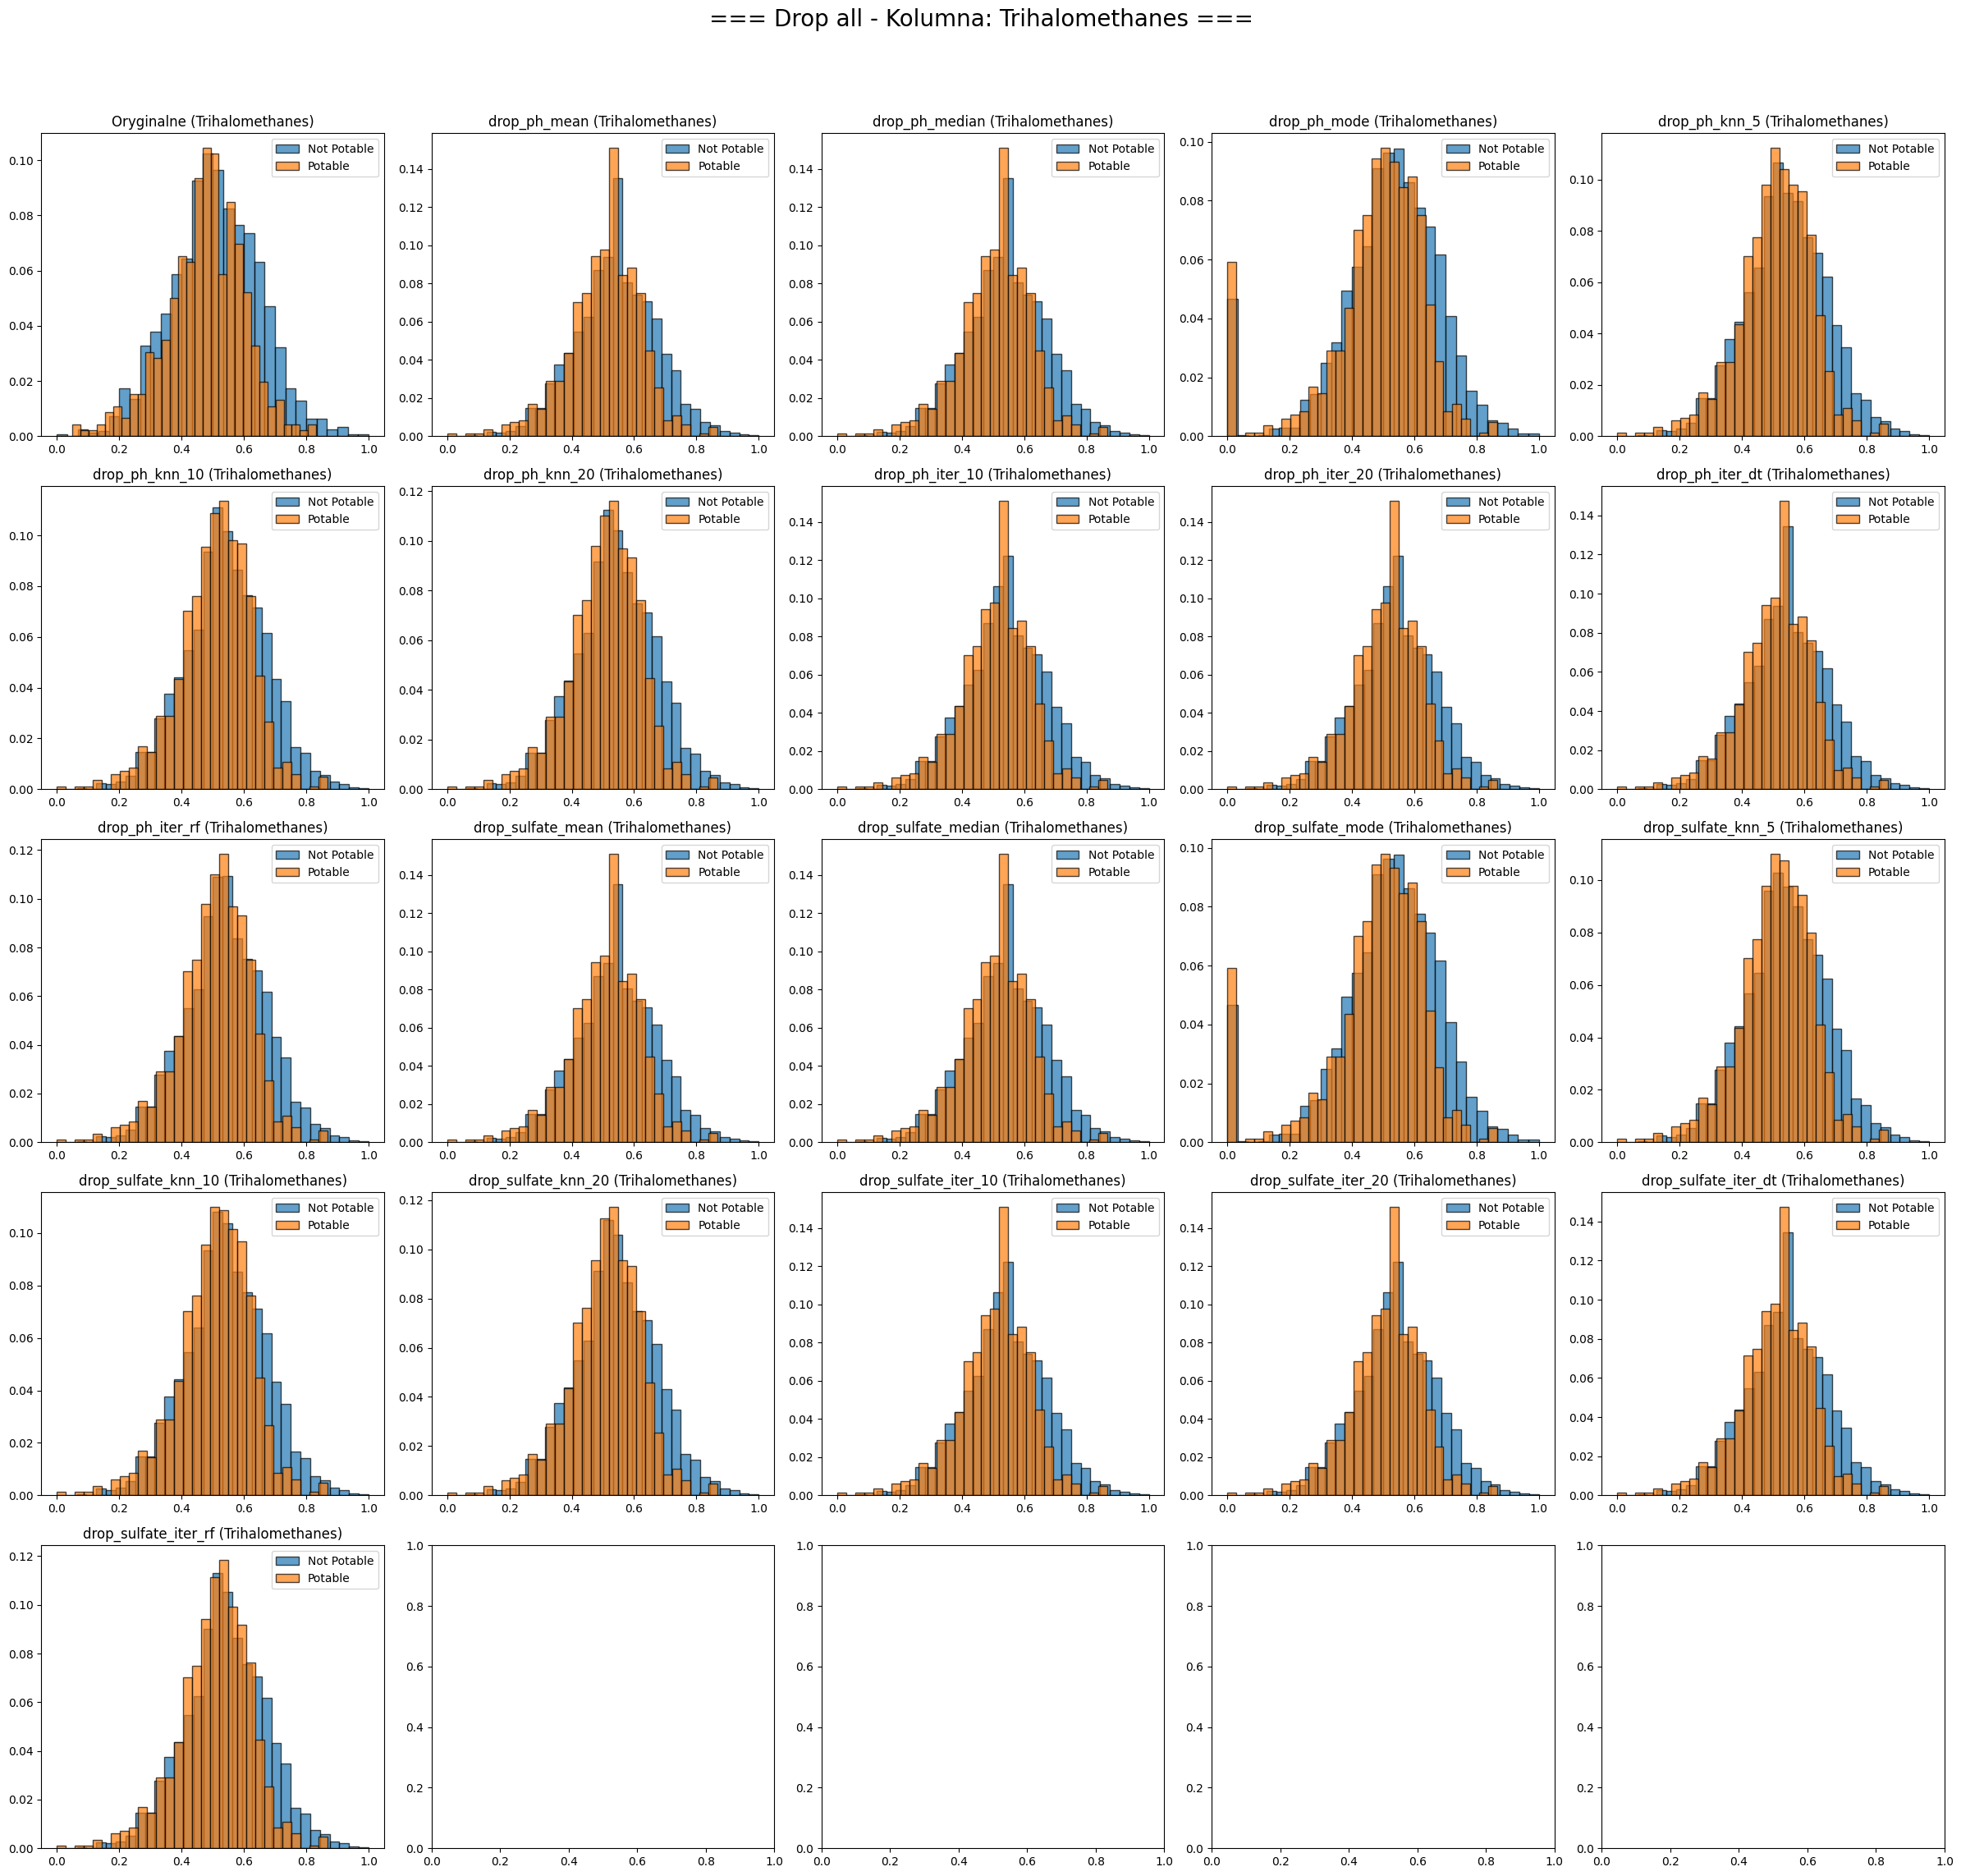

In [92]:
def plot_normalized_histogram(cl0, cl1, ax, title):
    # Normalizacja przez liczność klasy
    weights_0 = np.ones_like(cl0) / len(cl0) if len(cl0) > 0 else None
    weights_1 = np.ones_like(cl1) / len(cl1) if len(cl1) > 0 else None

    # Rysowanie histogramu z normalizacją
    ax.hist(cl0, bins=30, alpha=0.7, label='Not Potable', edgecolor='black', weights=weights_0)
    ax.hist(cl1, bins=30, alpha=0.7, label='Potable', edgecolor='black', weights=weights_1)
    ax.set_title(title)
    ax.legend()

def plot_imputation_comparison(df_dict, column_names):
    for col in column_names:
        fig, axes = plt.subplots(5, 5, figsize=(24, 24))  # Siatka 5x5
        plt.subplots_adjust(hspace=0.5)

        plot_index = 0
        for method_name, data_dict in df_dict.items():
            # Nagłówek dla metody usunięcia
            fig.suptitle(f'=== {method_name} - Kolumna: {col} ===', fontsize=20)

            for impute_method, df in data_dict.items():
                if col not in df.columns:
                    continue
                
                # Pobieranie danych z klasą 0 i 1
                cl0 = df.loc[df["Potability"] == 0, col].dropna()
                cl1 = df.loc[df["Potability"] == 1, col].dropna()

                # Wybór osi na wykresie
                ax = axes[plot_index // 5, plot_index % 5]
                plot_normalized_histogram(cl0, cl1, ax, f'{impute_method} ({col})')

                plot_index += 1

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Dostosowanie układu
        plt.show()

# Przykład użycia
visualization_dict = {
    "Drop": {"Oryginalne": df_drop},
    "Drop ph": create_imputed_datasets(df_drop_ph, "drop_ph"),
    "Drop sulfate": create_imputed_datasets(df_drop_sulfate, "drop_sulfate"),
    "Drop trihalomethanes": create_imputed_datasets(df_drop_trihalomethanes, "drop_trihalomethanes"),
    "Drop all": create_imputed_datasets(df_drop_all, "drop_all"),
}

# Wywołanie funkcji dla wybranych kolumn
plot_imputation_comparison(visualization_dict, ["ph", "Sulfate", "Trihalomethanes"])


In [ ]:
def evaluate_models(datasets):
    results = {}

    for method, data_dict in datasets.items():
        method_results = {}
        for imput_method, df_imputed in data_dict.items():
            X_train, X_test, y_train, y_test = split_data(df_imputed)

            # KNN
            knn = KNeighborsClassifier(n_neighbors=7, weights="distance", metric="manhattan")
            acc_knn, prec_knn, recall_knn, f1_knn = train(knn, X_train, X_test, y_train, y_test)

            # SVM
            svm = SVC(kernel="rbf", C=10, gamma=0.1, class_weight='balanced')
            acc_svm, prec_svm, recall_svm, f1_svm = train(svm, X_train, X_test, y_train, y_test)

            # Decision Tree
            dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, criterion='entropy')
            acc_dt, prec_dt, recall_dt, f1_dt = train(dt, X_train, X_test, y_train, y_test)

            # Zapis wyników
            method_results[imput_method] = {
                "KNN": (acc_knn, prec_knn, recall_knn, f1_knn),
                "SVM": (acc_svm, prec_svm, recall_svm, f1_svm),
                "DecisionTree": (acc_dt, prec_dt, recall_dt, f1_dt),
            }
        
        results[method] = method_results

    return results

# Tworzenie zestawów danych dla porównania modeli
comparison_datasets = {
    "Drop": create_imputed_datasets(df_drop, "drop"),
    "Drop ph": create_imputed_datasets(df_drop_ph, "drop_ph"),
    "Drop sulfate": create_imputed_datasets(df_drop_sulfate, "drop_sulfate"),
    "Drop trihalomethanes": create_imputed_datasets(df_drop_trihalomethanes, "drop_trihalomethanes"),
    "Drop all": create_imputed_datasets(df_drop_all, "drop_all"),
}

# Wyniki modeli
model_results = evaluate_models(comparison_datasets)

# Wyświetlenie wyników
for method, results in model_results.items():
    print(f"\nMetoda: {method}")
    for imput_method, scores in results.items():
        print(f"  Imputacja: {imput_method}")
        for model_name, (acc, prec, rec, f1) in scores.items():
            print(f"    {model_name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-score={f1:.4f}")


In [ ]:
with open("Wyniki_gridSearch.txt", "w") as f:
    for name, X_train, X_test, y_train, y_test in [
        ("Drop", X_train_drop, X_test_drop, y_train_drop, y_test_drop),
        ("Mean", X_train_mean, X_test_mean, y_train_mean, y_test_mean),
        ("Median", X_train_median, X_test_median, y_train_median, y_test_median),
        ("Mode", X_train_mode, X_test_mode, y_train_mode, y_test_mode),
        ("KNN dla k = 5", X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5),
        ("KNN dla k = 10", X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10),
        ("KNN dla k = 20", X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20),
        ("Iterative (10 iteracji)", X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10),
        ("Iterative (20 iteracji)", X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20),
        ("Iterative (DecisionTree)", X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt),
        ("Iterative (RandomForest)", X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf)
    ]:
        f.write(f"\nWyniki dla metody: {name}\n")

        acc_knn, prec_knn, recall_knn, f1_knn = train(knn, X_train, X_test, y_train, y_test)
        f.write(f"KNN: Accuracy: {acc_knn:.4f}, Precision: {prec_knn:.4f}, Recall: {recall_knn:.4f}, F1-score: {f1_knn:.4f}\n")

        acc_svm, prec_svm, recall_svm, f1_svm = train(svm, X_train, X_test, y_train, y_test)
        f.write(f"SVM: Accuracy: {acc_svm:.4f}, Precision: {prec_svm:.4f}, Recall: {recall_svm:.4f}, F1-score: {f1_svm:.4f}\n")

        acc_dt, prec_dt, recall_dt, f1_dt = train(dt, X_train, X_test, y_train, y_test)
        f.write(f"Decision Tree: Accuracy: {acc_dt:.4f}, Precision: {prec_dt:.4f}, Recall: {recall_dt:.4f}, F1-score: {f1_dt:.4f}\n")


Po konsultacjach 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Najlepsze parametry dla KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Najlepszy wynik F1: 0.4440422156308202
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Najlepsze parametry dla SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Najlepszy wynik F1: 0.08264378288464533
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Najlepsze parametry dla DecisionTreeClassifier: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5}
Najlepszy wynik F1: 0.7069081123626578
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Najlepsze parametry dla KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}
Najlepszy wynik F1: 0.5564378108143184
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Najlepsze parametry dla SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Najlepszy wynik F1: 0.3935331937344123
Fitting 5 folds for each of 

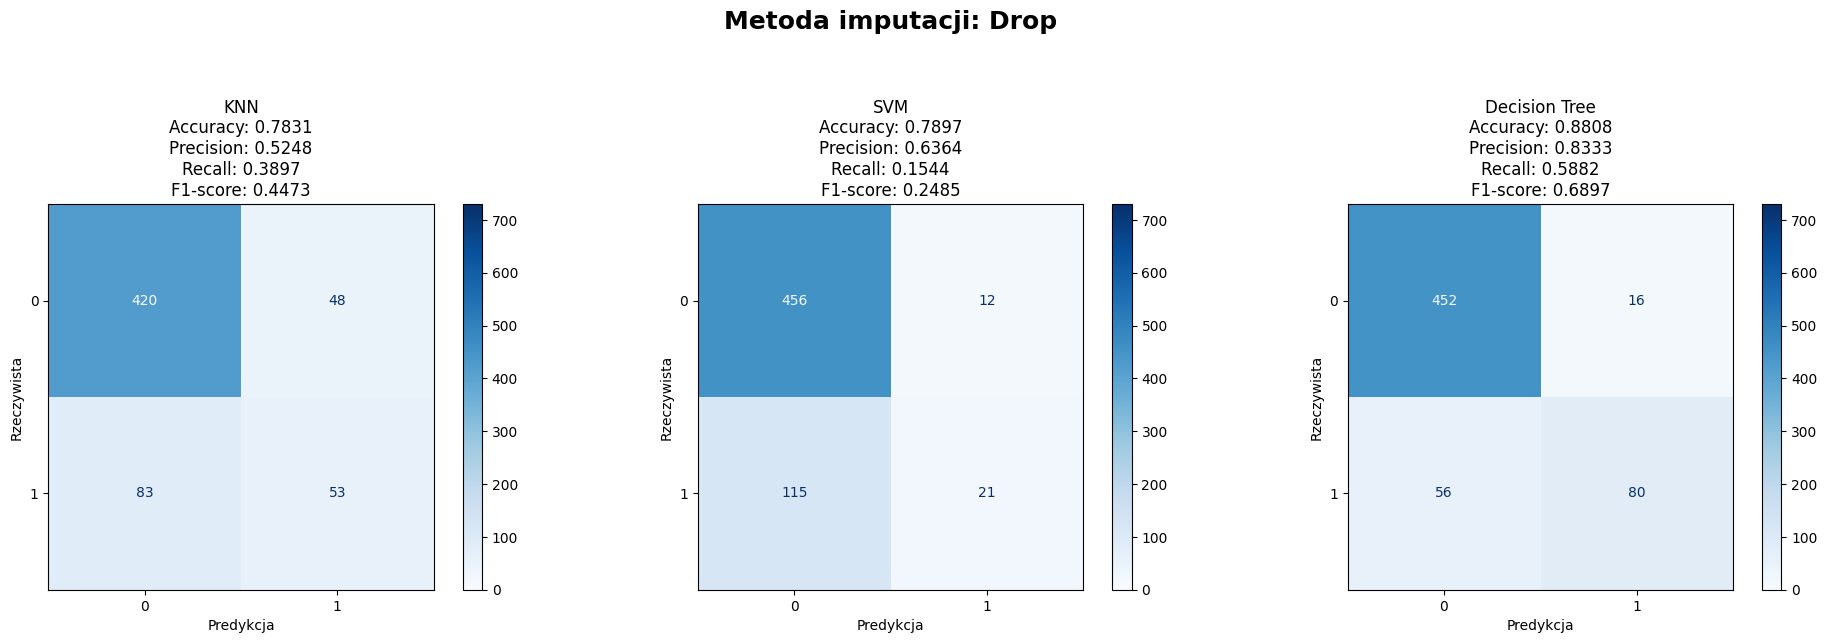

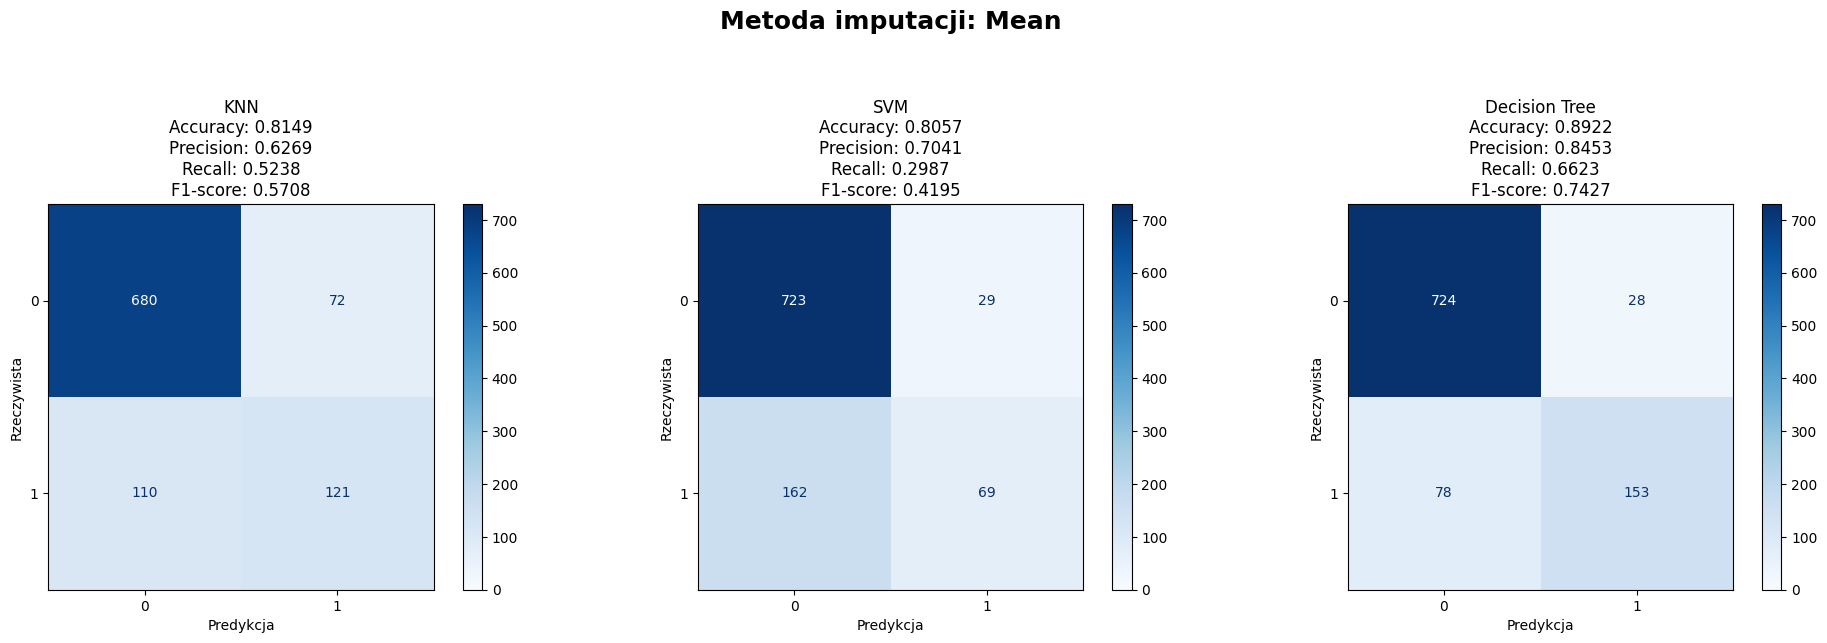

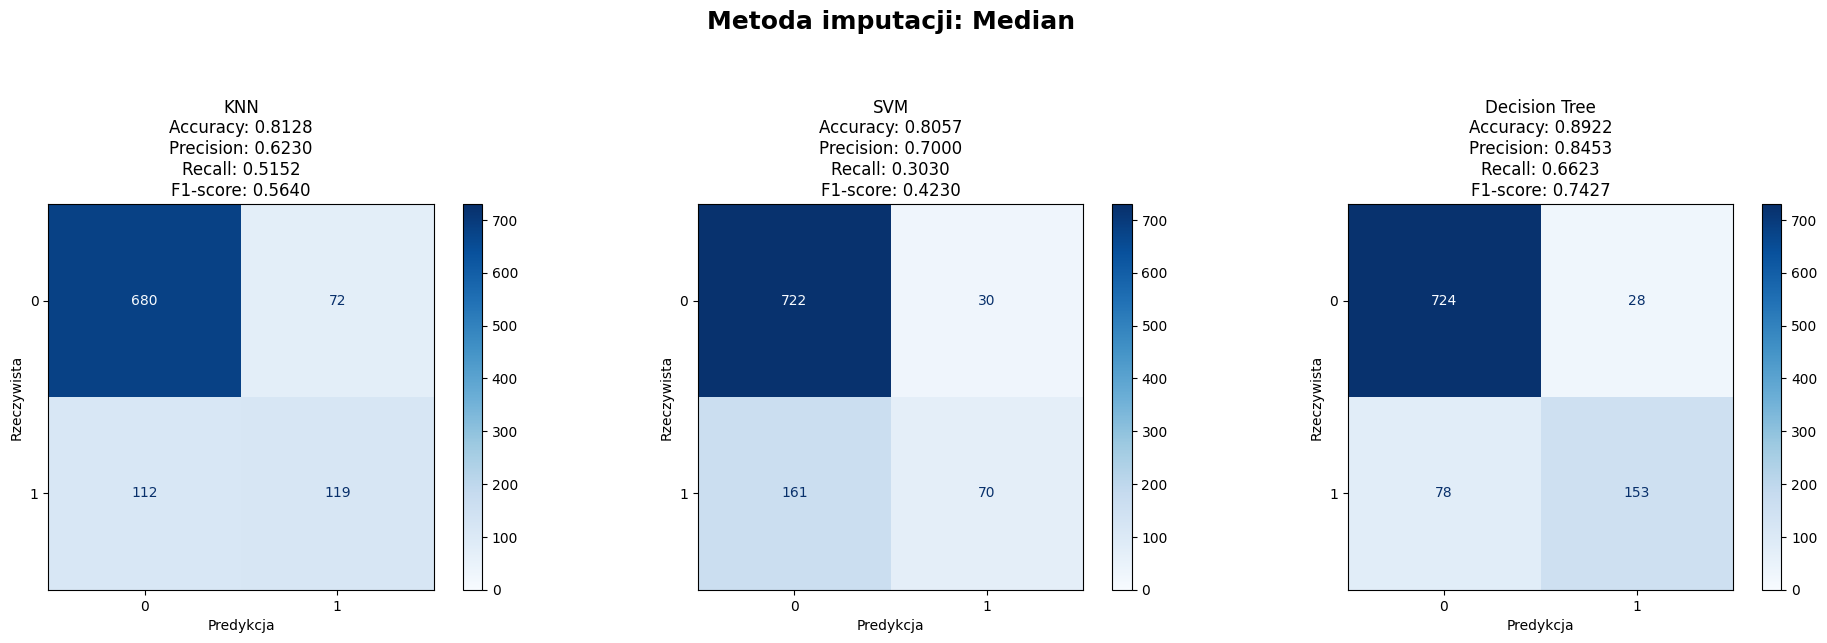

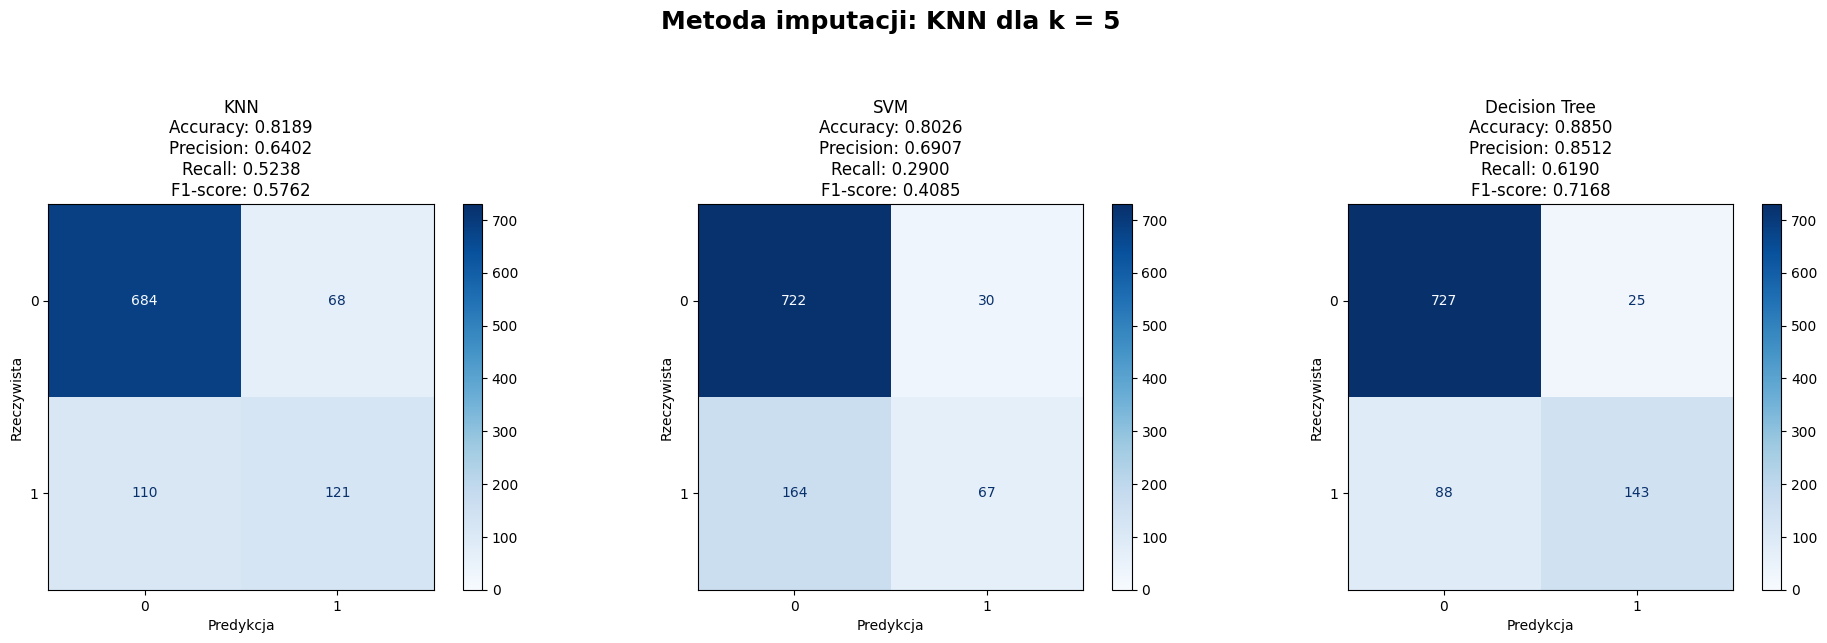

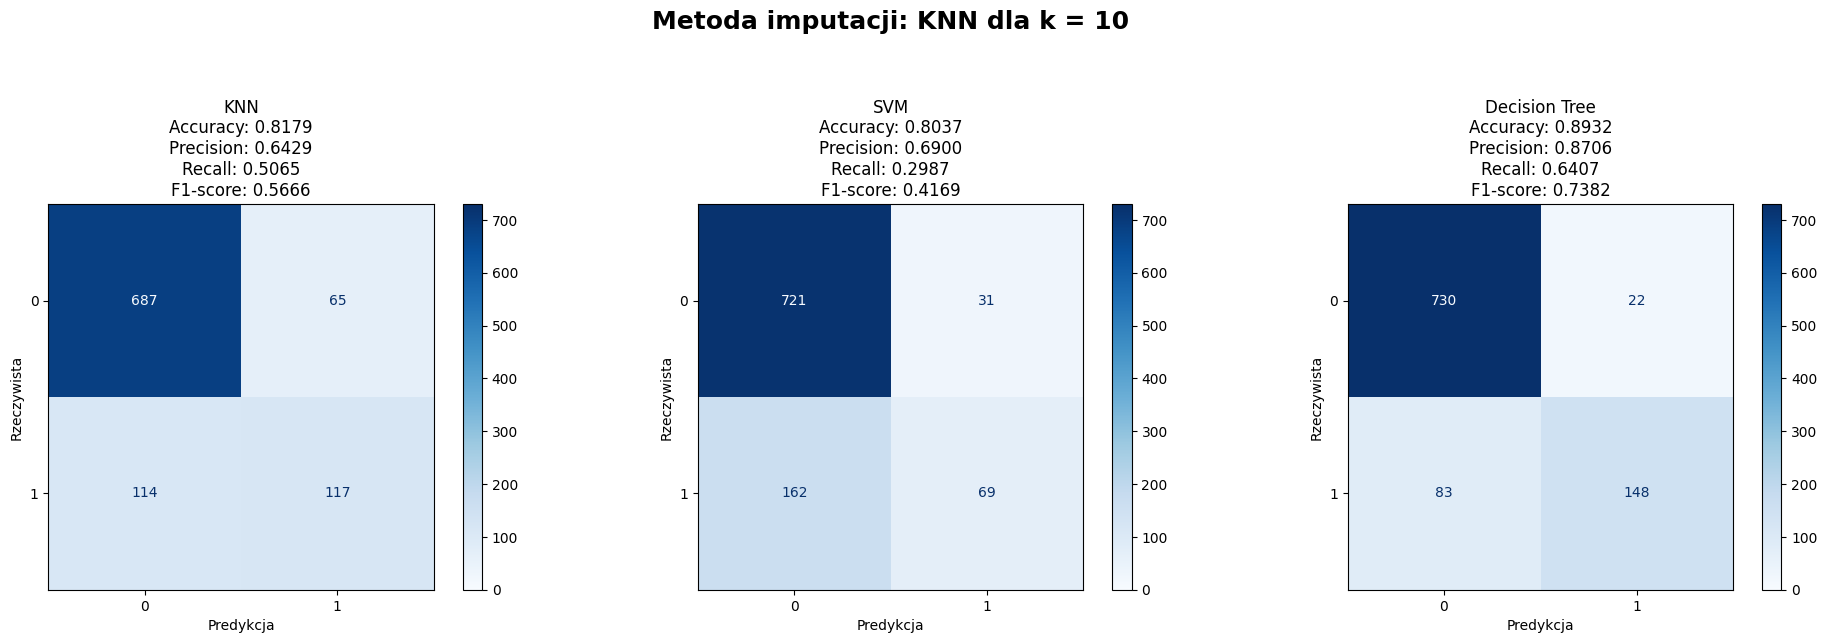

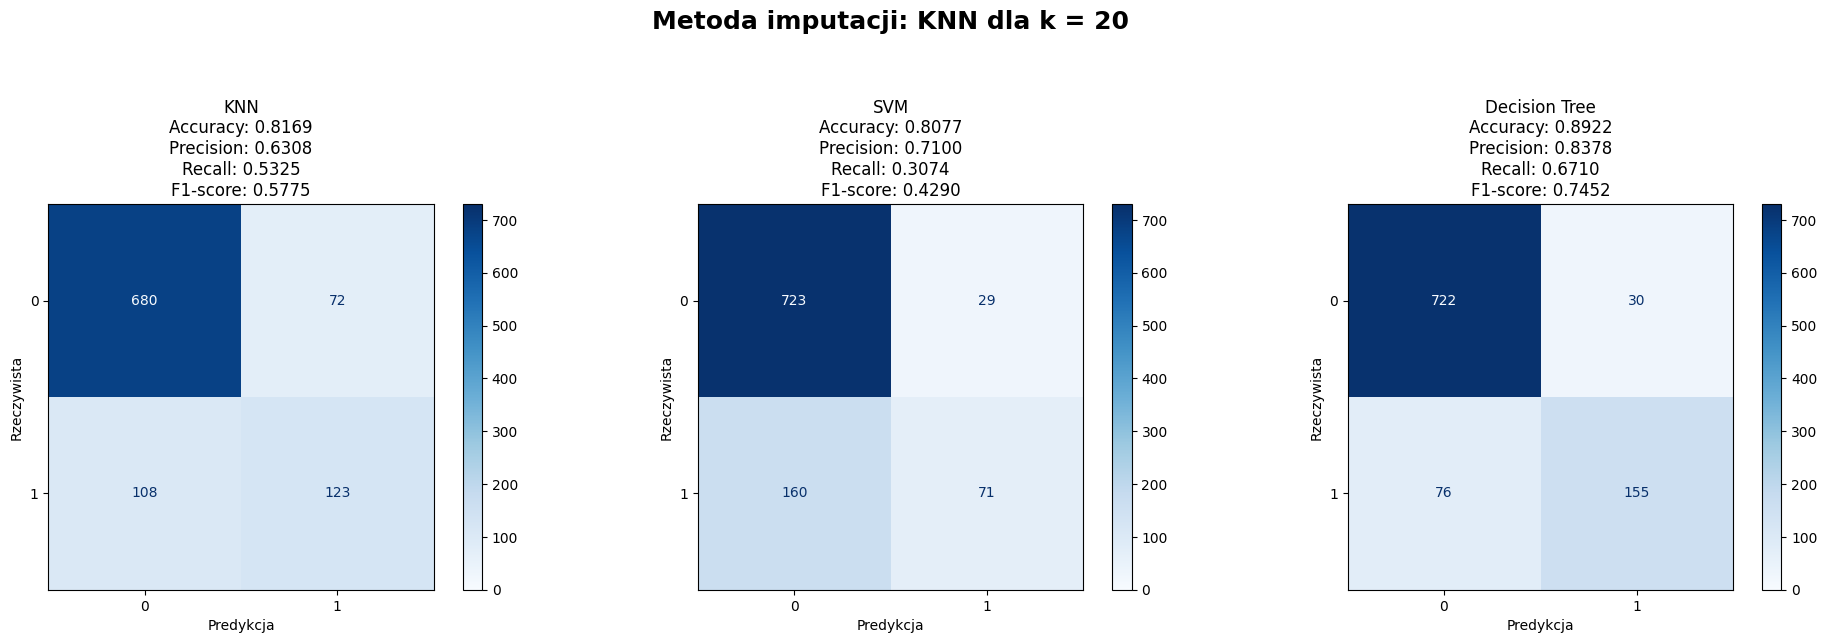

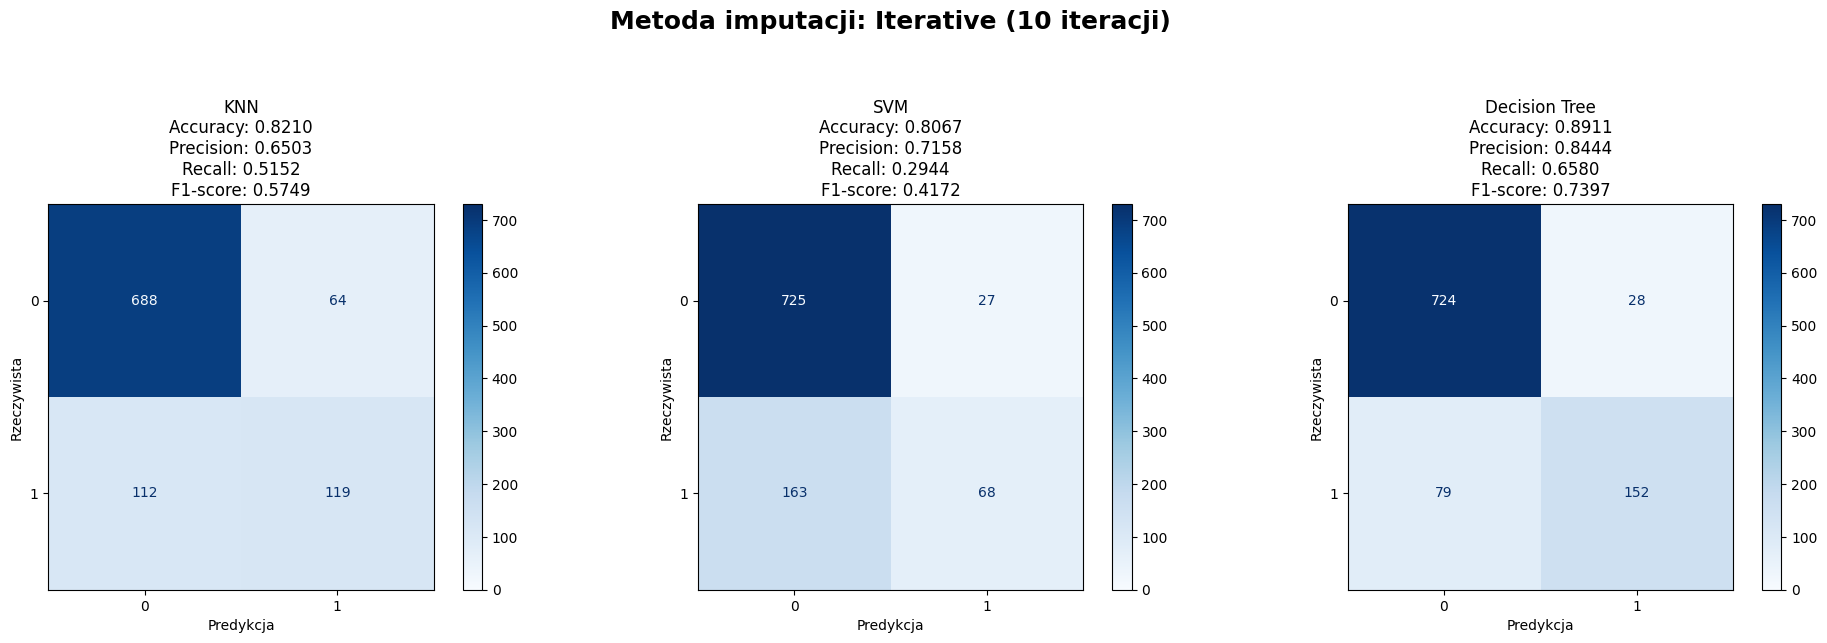

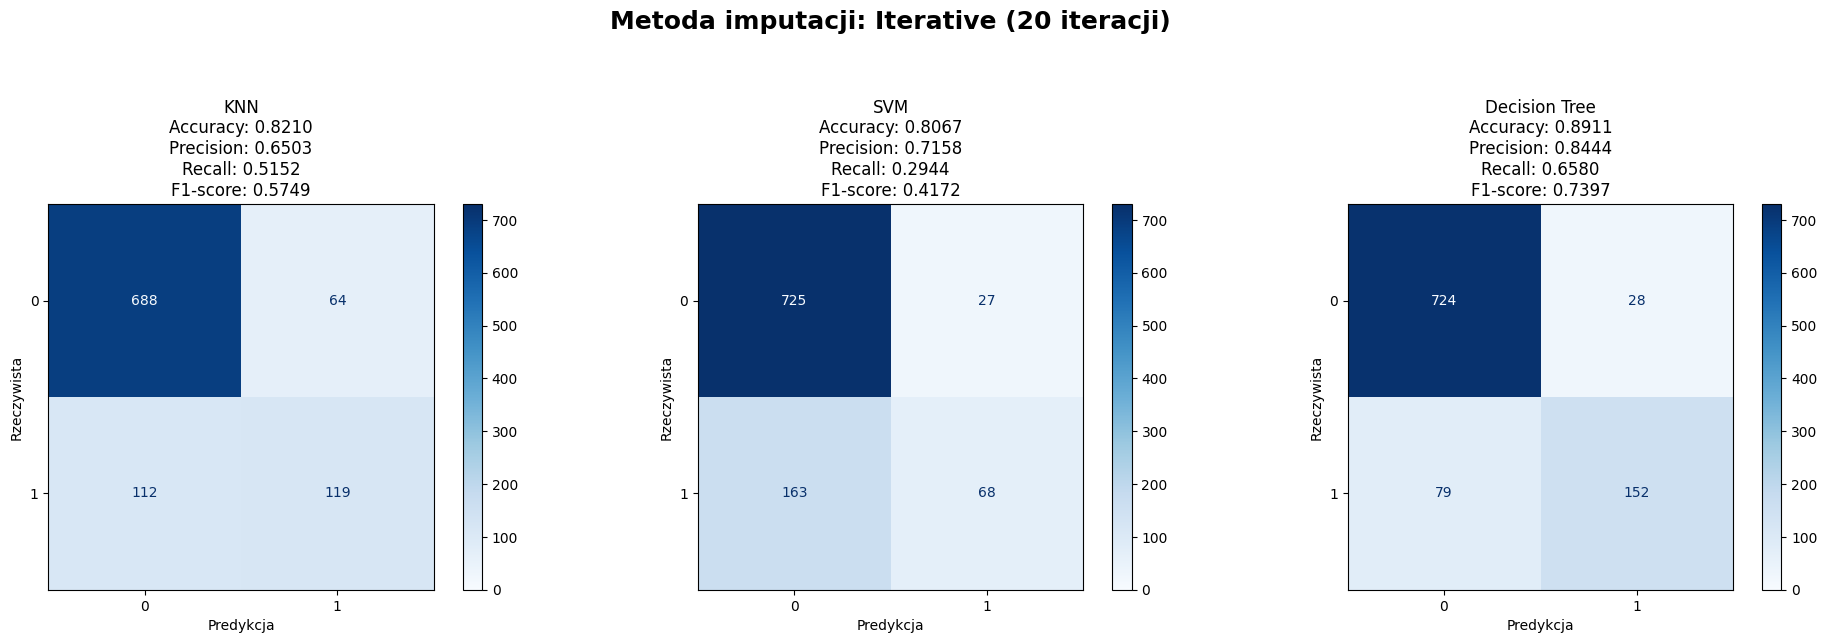

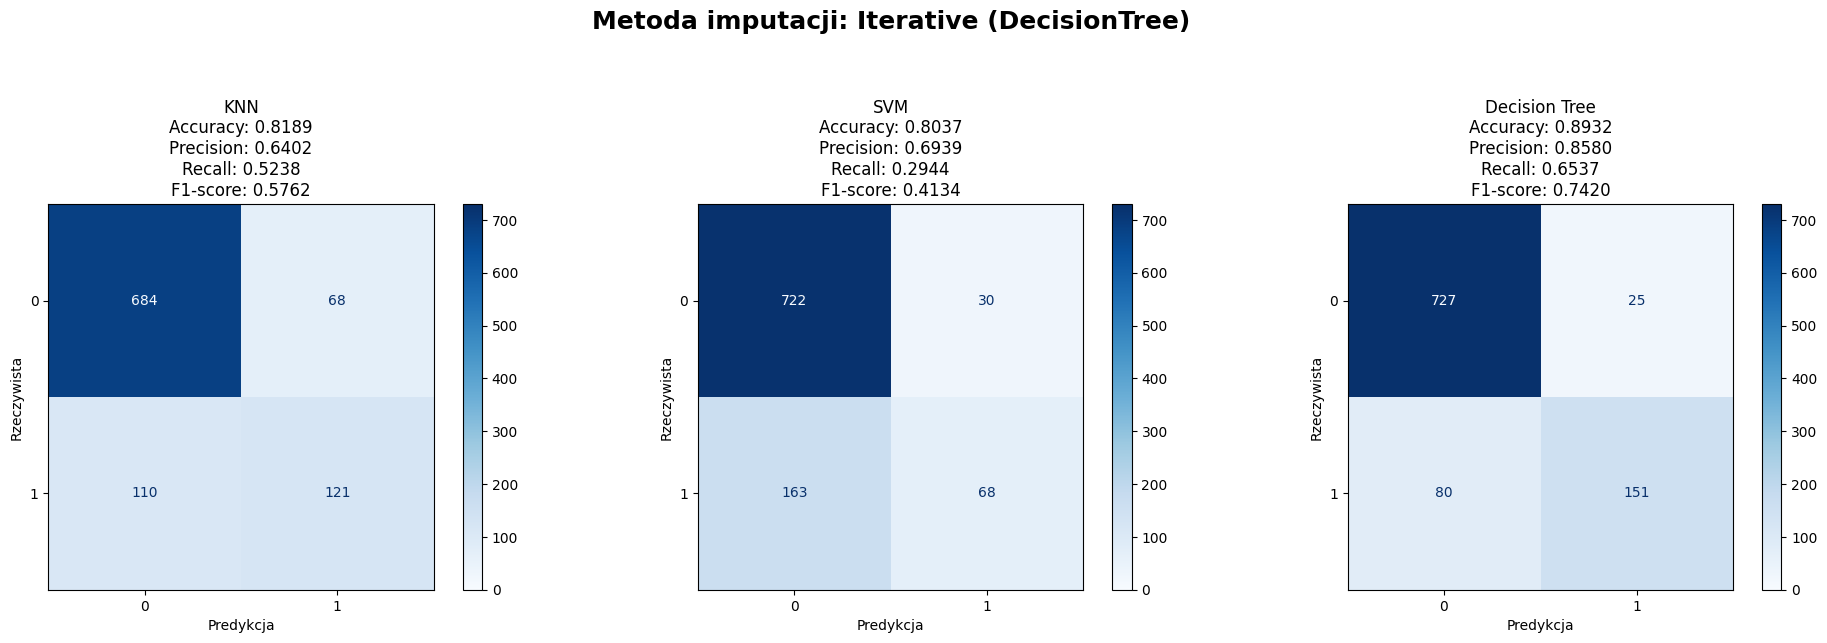

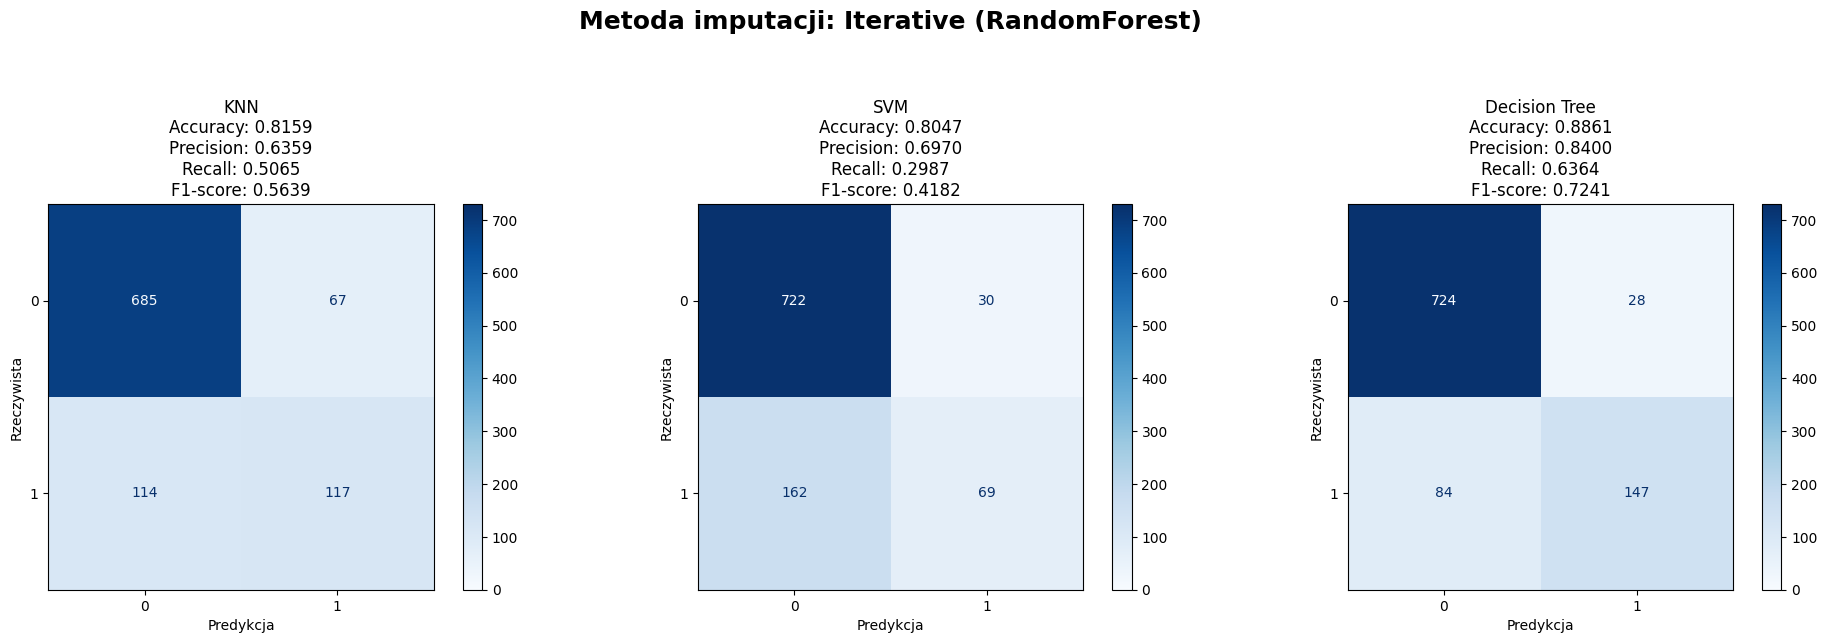

In [ ]:
def plot_grouped_confusion_matrices(results):
    # Znajdź maksymalną wartość wśród wszystkich macierzy, aby ustawić wspólny gradient
    max_value = 0
    for method_name, metrics in results.items():
        for model_name, (y_true, y_pred, _, _, _, _) in metrics.items():
            cm = confusion_matrix(y_true, y_pred)
            max_value = max(max_value, cm.max())

    # Iterujemy przez każdą metodę imputacji
    for method_name, metrics in results.items():
        # Tworzenie nowego wykresu dla każdej grupy (3 macierze obok siebie)
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(f'Metoda imputacji: {method_name}', fontsize=18, fontweight='bold', y=1.05)

        for col, (model_name, (y_true, y_pred, acc, prec, recall, f1)) in enumerate(metrics.items()):
            # Sprawdzamy czy liczba macierzy nie przekracza 3 w jednym wierszu
            if col >= 3:
                break

            # Macierz pomyłek
            cm = confusion_matrix(y_true, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            # Wykres z ustawieniem wspólnego zasięgu kolorów (vmin i vmax)
            disp.plot(ax=axes[col], cmap="Blues", values_format='d')
            im = axes[col].images[0]
            im.set_clim(0, max_value)  # Ustawienie wspólnej skali kolorów

            # Dodanie wyników nad macierzą
            axes[col].set_title(f'{model_name}\n'
                                f'Accuracy: {acc:.4f}\n'
                                f'Precision: {prec:.4f}\n'
                                f'Recall: {recall:.4f}\n'
                                f'F1-score: {f1:.4f}', fontsize=12)
            axes[col].set_xlabel("Predykcja")
            axes[col].set_ylabel("Rzeczywista")

        plt.tight_layout(pad=3.0)
        plt.show()

# Zbieranie wyników do wykresu
results = {}

for name, X_train, X_test, y_train, y_test in [
    ("Drop", X_train_drop, X_test_drop, y_train_drop, y_test_drop),
    ("Mean", X_train_mean, X_test_mean, y_train_mean, y_test_mean),
    ("Median", X_train_median, X_test_median, y_train_median, y_test_median),
    ("KNN dla k = 5", X_train_knn_5, X_test_knn_5, y_train_knn_5, y_test_knn_5),
    ("KNN dla k = 10", X_train_knn_10, X_test_knn_10, y_train_knn_10, y_test_knn_10),
    ("KNN dla k = 20", X_train_knn_20, X_test_knn_20, y_train_knn_20, y_test_knn_20),
    ("Iterative (10 iteracji)", X_train_iter_10, X_test_iter_10, y_train_iter_10, y_test_iter_10),
    ("Iterative (20 iteracji)", X_train_iter_20, X_test_iter_20, y_train_iter_20, y_test_iter_20),
    ("Iterative (DecisionTree)", X_train_iter_dt, X_test_iter_dt, y_train_iter_dt, y_test_iter_dt),
    ("Iterative (RandomForest)", X_train_iter_rf, X_test_iter_rf, y_train_iter_rf, y_test_iter_rf)
]:
    # Inicjalizacja słownika dla konkretnej metody
    results[name] = {}

    # KNN
    best_knn = grid_search_best_model(KNeighborsClassifier(), param_grids['KNN'], X_train, y_train)
    acc_knn, prec_knn, recall_knn, f1_knn = train(best_knn, X_train, X_test, y_train, y_test)
    y_pred_knn = best_knn.predict(X_test)
    results[name]["KNN"] = (y_test, y_pred_knn, acc_knn, prec_knn, recall_knn, f1_knn)

    # SVM
    best_svm = grid_search_best_model(SVC(), param_grids['SVM'], X_train, y_train)
    acc_svm, prec_svm, recall_svm, f1_svm = train(best_svm, X_train, X_test, y_train, y_test)
    y_pred_svm = best_svm.predict(X_test)
    results[name]["SVM"] = (y_test, y_pred_svm, acc_svm, prec_svm, recall_svm, f1_svm)

    # Decision Tree
    best_dt = grid_search_best_model(DecisionTreeClassifier(), param_grids['DecisionTree'], X_train, y_train)
    acc_dt, prec_dt, recall_dt, f1_dt = train(best_dt, X_train, X_test, y_train, y_test)
    y_pred_dt = best_dt.predict(X_test)
    results[name]["Decision Tree"] = (y_test, y_pred_dt, acc_dt, prec_dt, recall_dt, f1_dt)

# Rysowanie macierzy pomyłek w grupach po 3
plot_grouped_confusion_matrices(results)


In [ ]:
with open("Wyniki_optimal.txt", "w") as f:
    for name, metrics in results.items():
        f.write(f"\nWyniki dla metody: {name}\n")
        for model_name, (y_true, y_pred, acc, prec, recall, f1) in metrics.items():
            f.write(f"{model_name}: Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")
    f.write("\nPodsumowanie wszystkich najlepszych modeli po Grid Search\n")
